In [21]:
import os
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import combinations
from matplotlib.lines import Line2D  # 用于创建自定义图例
from networkx.algorithms import community as nx_comm
from IPython.display import display  # 用于美化输出

# --- Configurations ---
input_filename = 'Spotify_Weekly_Data_Cleaned.csv'

# === 新增：统一输出文件夹配置 ===
output_dir = 'RQ3_results'
os.makedirs(output_dir, exist_ok=True)

# 所有输出文件路径集中到同一目录下
output_centrality_filename = os.path.join(output_dir, 'artist_centrality_scores.csv')
output_community_summary_filename = os.path.join(output_dir, 'community_summary.csv')
output_top10_summary_filename = os.path.join(output_dir, 'top_10_collaborators_summary.csv')
output_correlation_plot = os.path.join(output_dir, 'hotness_vs_points_correlation.png')

def analyze_rq3_network_as_tables(file_path):
    """
    执行 RQ3 的深度分析，将所有输出文件保存到统一文件夹 RQ3_results 下。
    """
    try:
        # Step 1: 加载并准备数据 ---
        print("--- Step 1: Loading and preparing data ---")
        df = pd.read_csv(file_path, sep=';')
        
        if isinstance(df['Artist (Ind.)'].iloc[0], str):
            df['Artist (Ind.)'] = df['Artist (Ind.)'].apply(ast.literal_eval)
            df['Continent'] = df['Continent'].apply(ast.literal_eval)
            df['Nationality'] = df['Nationality'].apply(ast.literal_eval)

        print(f"File loaded successfully. Shape: {df.shape}")

        # 数据验证
        print("\n--- Additional Data Validation ---")
        print("Distribution of Artist_Count:")
        print(df['Artist_Count'].describe())
        collab_df = df[df['Artist_Count'] > 1].copy()

        # Step 2: 构建艺人合作网络
        print("\n--- Step 2: Building the artist collaboration network ---")
        edge_weights = defaultdict(int)
        for artists_list in collab_df['Artist (Ind.)']:
            unique_artists = sorted(list(set(artists_list)))
            if len(unique_artists) > 1:
                for artist1, artist2 in combinations(unique_artists, 2):
                    edge = tuple(sorted((artist1, artist2)))
                    edge_weights[edge] += 1
        
        G = nx.Graph()
        for (artist1, artist2), weight in edge_weights.items():
            G.add_edge(artist1, artist2, weight=weight)
            
        print(f"Network built successfully.")
        print(f"Number of artists (nodes): {G.number_of_nodes()}")
        print(f"Number of collaborations (edges): {G.number_of_edges()}")

        # Step 3: 计算网络中心性指标
        # === Step 3: 计算网络中心性指标 ===
        print("\n--- Step 3: Calculating multiple network centrality metrics ---")
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

        centrality_df = pd.DataFrame({
            'Artist': list(degree_centrality.keys()),
            'Degree_Centrality': list(degree_centrality.values()),
            'Betweenness_Centrality': list(betweenness_centrality.values()),
            'Closeness_Centrality': list(closeness_centrality.values()),
            'Eigenvector_Centrality': list(eigenvector_centrality.values())
        }).sort_values(by='Degree_Centrality', ascending=False).reset_index(drop=True)

        # === Step 4: 社区发现与表格化分析 ===
        print("\n--- Step 4: Performing community detection and generating summary tables ---")

        resolutions = [0.6, 0.8, 1.0, 1.2]
        mod_results = []

        print("Testing multiple resolution parameters for Louvain modularity optimization:")
        for r in resolutions:
            comms = nx_comm.louvain_communities(G, resolution=r, seed=42)
            modularity = nx_comm.modularity(G, comms)
            mod_results.append((r, len(comms), modularity))
            print(f"  resolution={r:.2f} → communities={len(comms):3d}, modularity={modularity:.4f}")

        best_r, best_n, best_mod = max(mod_results, key=lambda x: x[2])
        print(f"\nBest resolution selected: {best_r:.2f} (communities={best_n}, modularity={best_mod:.4f})")

        communities = nx_comm.louvain_communities(G, resolution=best_r, seed=42)
        node_to_community = {node: i for i, community in enumerate(communities) for node in community}
        centrality_df['Community_ID'] = centrality_df['Artist'].map(node_to_community)
        centrality_df.to_csv(output_centrality_filename, index=False, sep=';', encoding='utf-8-sig')
        print(f"✅ Centrality + Community_ID saved to '{output_centrality_filename}'")


        print(f"Centrality scores saved to '{output_centrality_filename}'")
        display(centrality_df.head(10))

        # Step 4: 社区发现与表格化分析
        print("\n--- Step 4: Performing community detection and generating summary tables ---")

        # === 新增：自动化社区划分测试 ===
        resolutions = [0.6, 0.8, 1.0, 1.2]
        mod_results = []

        print("Testing multiple resolution parameters for Louvain modularity optimization:")
        for r in resolutions:
            comms = nx_comm.louvain_communities(G, resolution=r, seed=42)
            modularity = nx_comm.modularity(G, comms)
            mod_results.append((r, len(comms), modularity))
            print(f"  resolution={r:.2f} → communities={len(comms):3d}, modularity={modularity:.4f}")

        # === 找出模块化最优的参数 ===
        best_r, best_n, best_mod = max(mod_results, key=lambda x: x[2])
        print(f"\nBest resolution selected: {best_r:.2f} "
            f"(communities={best_n}, modularity={best_mod:.4f})")

        # === 稳定性验证（多次运行取均值±方差）===
        mod_stability = []
        for i in range(5):
            comms_test = nx_comm.louvain_communities(G, resolution=best_r, seed=42 + i)
            mod_stability.append(nx_comm.modularity(G, comms_test))
        mean_mod = np.mean(mod_stability)
        std_mod = np.std(mod_stability)
        print(f"Stability check: Mean modularity = {mean_mod:.4f} ± {std_mod:.4f}")

        # === 使用最优分辨率参数进行最终划分 ===
        communities = nx_comm.louvain_communities(G, resolution=best_r, seed=42)
        communities = sorted(communities, key=len, reverse=True)
        print(f"Final community detection completed.")
        print(f"Found {len(communities)} communities. Top 5 sizes: {[len(c) for c in communities[:5]]}")
        print(f"Final modularity = {nx_comm.modularity(G, communities):.4f}")

        # === 后续逻辑保持不变 ===
        node_to_community = {node: i for i, community in enumerate(communities) for node in community}
        centrality_df['Community_ID'] = centrality_df['Artist'].map(node_to_community)

        artist_continent_map = {}
        artist_nationality_map = {}
        unique_collab_df = collab_df.drop_duplicates(subset=['id'])
        for _, row in unique_collab_df.iterrows():
            artists = row['Artist (Ind.)']
            continents = row['Continent']
            nationalities = row['Nationality']
            if isinstance(artists, list) and isinstance(continents, list) and isinstance(nationalities, list):
                for artist, continent, nationality in zip(artists, continents, nationalities):
                    if artist not in artist_continent_map:
                        artist_continent_map[artist] = continent
                        artist_nationality_map[artist] = nationality
        centrality_df['Continent'] = centrality_df['Artist'].map(artist_continent_map)
        centrality_df['Nationality'] = centrality_df['Artist'].map(artist_nationality_map)

        summary_data = []
        for i in range(min(5, len(communities))):
            community_df = centrality_df[centrality_df['Community_ID'] == i]
            leader = community_df.loc[community_df['Degree_Centrality'].idxmax()]
            top_members = community_df.head(5)['Artist'].tolist()
            continent_dist = community_df['Continent'].value_counts(normalize=True).head(2)
            summary_data.append({
                'Community_ID': i,
                'Total_Members': len(community_df),
                'Community_Leader': leader['Artist'],
                'Leader_Degree': f"{leader['Degree_Centrality']:.3f}",
                'Top_5_Members': ", ".join(top_members),
                'Continent_Distribution': (
                    f"{continent_dist.index[0]} ({continent_dist.iloc[0]:.0%})"
                    if not continent_dist.empty else "N/A"
                )
            })

        community_summary_df = pd.DataFrame(summary_data)
        display(community_summary_df)
        community_summary_df.to_csv(output_community_summary_filename, index=False, sep=';', encoding='utf-8-sig')
        print(f"Community summary saved to '{output_community_summary_filename}'")

        # Step 5: 生成 Top 10 合作者表
        print("\n--- Step 5: Generating Top 10 Collaborators Analysis Table ---")
        top_10_artists = centrality_df.head(10).copy()
        top_10_artists['Collaboration_Count'] = top_10_artists['Artist'].apply(lambda x: G.degree[x])
        top_10_summary = top_10_artists[['Artist', 'Collaboration_Count', 'Nationality', 'Continent', 'Degree_Centrality']]
        display(top_10_summary)
        top_10_summary.to_csv(output_top10_summary_filename, index=False, sep=';', encoding='utf-8-sig')
        print(f"Top 10 collaborators summary saved to '{output_top10_summary_filename}'")

        # Step 6: 验证合作效应
        print("\n--- Step 6: Validating the 'Collaboration Effect' ---")
        artist_to_degree = centrality_df.set_index('Artist')['Degree_Centrality'].to_dict()

        def get_collaborator_hotness(artists):
            if not isinstance(artists, list) or len(artists) < 2:
                return 0, 0
            degrees = [artist_to_degree.get(artist, 0) for artist in artists]
            return max(degrees), np.mean(degrees)

        hotness_scores = collab_df['Artist (Ind.)'].apply(get_collaborator_hotness)
        collab_df['Max_Collaborator_Hotness'] = [s[0] for s in hotness_scores]
        collab_df['Mean_Collaborator_Hotness'] = [s[1] for s in hotness_scores]

        corr_max = collab_df[['Max_Collaborator_Hotness', 'Points (Total)']].corr().iloc[0, 1]
        corr_mean = collab_df[['Mean_Collaborator_Hotness', 'Points (Total)']].corr().iloc[0, 1]
        print(f"Correlation between Max Collaborator Hotness and Points (Total): {corr_max:.3f}")
        print(f"Correlation between Mean Collaborator Hotness and Points (Total): {corr_mean:.3f}")

        plt.figure(figsize=(10, 6))
        sns.regplot(x='Max_Collaborator_Hotness', y='Points (Total)', data=collab_df,
                    scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
        plt.title('Collaboration Hotness vs. Song Points', fontsize=16)
        plt.xlabel('Max Collaborator Degree Centrality (Hotness)')
        plt.ylabel('Points (Total)')
        plt.tight_layout()
        plt.savefig(output_correlation_plot)
        plt.close()
        print(f"Correlation plot saved to '{output_correlation_plot}'")

    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f"An error occurred: {e}. Please check the input file and its format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 主程序入口
if __name__ == "__main__":
    analyze_rq3_network_as_tables(input_filename)


--- Step 1: Loading and preparing data ---
File loaded successfully. Shape: (464475, 21)

--- Additional Data Validation ---
Distribution of Artist_Count:
count    464475.00000
mean          1.39465
std           0.80745
min           1.00000
25%           1.00000
50%           1.00000
75%           2.00000
max           9.00000
Name: Artist_Count, dtype: float64

--- Step 2: Building the artist collaboration network ---
Network built successfully.
Number of artists (nodes): 1561
Number of collaborations (edges): 3037

--- Step 3: Calculating multiple network centrality metrics ---

--- Step 4: Performing community detection and generating summary tables ---
Testing multiple resolution parameters for Louvain modularity optimization:
  resolution=0.60 → communities=185, modularity=0.6597
  resolution=0.80 → communities=191, modularity=0.7035
  resolution=1.00 → communities=192, modularity=0.7079
  resolution=1.20 → communities=192, modularity=0.7053

Best resolution selected: 1.00 (comm

,Artist,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Eigenvector_Centrality,Community_ID
0,Bad Bunny,0.040385,0.046588,0.213913,0.255943,6
1,J Balvin,0.035897,0.098182,0.234427,0.216252,6
2,Ozuna,0.029487,0.017412,0.209056,0.249955,6
3,Anuel AA,0.029487,0.035785,0.215694,0.250623,6
4,Daddy Yankee,0.026923,0.026356,0.209267,0.203761,6
5,Rauw Alejandro,0.026282,0.013446,0.202467,0.200873,80
6,Myke Towers,0.023718,0.007724,0.196654,0.189300,6
7,David Guetta,0.023718,0.044152,0.200459,0.052909,154
8,Drake,0.023077,0.016766,0.194029,0.010836,5
9,Farruko,0.022436,0.024973,0.205683,0.192215,80



--- Step 4: Performing community detection and generating summary tables ---
Testing multiple resolution parameters for Louvain modularity optimization:
  resolution=0.60 → communities=185, modularity=0.6597
  resolution=0.80 → communities=191, modularity=0.7035
  resolution=1.00 → communities=192, modularity=0.7079
  resolution=1.20 → communities=192, modularity=0.7053

Best resolution selected: 1.00 (communities=192, modularity=0.7079)
Stability check: Mean modularity = 0.7062 ± 0.0011
Final community detection completed.
Found 192 communities. Top 5 sizes: [111, 104, 103, 97, 90]
Final modularity = 0.7079


,Community_ID,Total_Members,Community_Leader,Leader_Degree,Top_5_Members,Continent_Distribution
0,0,111,Drake,0.023,"Drake, Future, Young Thug, Travis Scott, Tripp...",Anglo-America (71%)
1,1,104,Bad Bunny,0.040,"Bad Bunny, J Balvin, Ozuna, Anuel AA, Daddy Ya...",Latin-America (57%)
2,2,103,David Guetta,0.024,"David Guetta, Becky G, Natti Natasha, Calvin H...",Europe (43%)
3,3,97,DJ Khaled,0.017,"DJ Khaled, Chance the Rapper, The Weeknd, Quav...",Anglo-America (76%)
4,4,90,Pharrell Williams,0.015,"Pharrell Williams, Tyler, The Creator, Capital...",Europe (73%)


Community summary saved to 'RQ3_results\community_summary.csv'

--- Step 5: Generating Top 10 Collaborators Analysis Table ---


,Artist,Collaboration_Count,Nationality,Continent,Degree_Centrality
0,Bad Bunny,63,Puerto Rico,Latin-America,0.040385
1,J Balvin,56,Colombia,Latin-America,0.035897
2,Ozuna,46,Puerto Rico,Latin-America,0.029487
3,Anuel AA,46,Puerto Rico,Latin-America,0.029487
4,Daddy Yankee,42,Puerto Rico,Latin-America,0.026923
5,Rauw Alejandro,41,Puerto Rico,Latin-America,0.026282
6,Myke Towers,37,Puerto Rico,Latin-America,0.023718
7,David Guetta,37,France,Europe,0.023718
8,Drake,36,Canada,Anglo-America,0.023077
9,Farruko,35,Puerto Rico,Latin-America,0.022436


Top 10 collaborators summary saved to 'RQ3_results\top_10_collaborators_summary.csv'

--- Step 6: Validating the 'Collaboration Effect' ---
Correlation between Max Collaborator Hotness and Points (Total): 0.120
Correlation between Mean Collaborator Hotness and Points (Total): 0.116
Correlation plot saved to 'RQ3_results\hotness_vs_points_correlation.png'


# RQ3 分析报告：艺人合作网络与成功预测

RQ3的核心任务是探索艺人之间的合作关系网络，并分析“与热门艺人合作”这一策略是否能有效提升歌曲的榜单表现。通过构建一个包含1561位艺人和3037条合作关系的复杂网络，我们得出了以下核心洞察：

## 发现一：音乐世界的“中心-边缘”结构与拉丁音乐圈的核心地位

我们的网络可视化清晰地揭示了音乐合作并非随机，而是呈现出明显的**“中心-边缘”结构**。少数艺人位于网络的绝对核心，拥有极其密集的合作关系，而大量艺人则处于网络的边缘，合作稀少。

### 关键数据点：
- **核心玩家**: 在影响力排名前十的艺人中，有 8位 来自拉丁美洲（如 Bad Bunny, J Balvin, Ozuna），清晰地表明拉丁音乐生态是当前全球流行音乐合作网络的核心驱动力。
- **地区聚集性**: 社区发现算法进一步证实了这一点，最大的几个“艺人圈子”分别以拉丁音乐、北美嘻哈和欧洲流行为主，显示出合作的高度地区性和流派聚集性。

## 发现二：关键角色的量化识别：“社交中心”与“文化桥梁”

通过多种中心性指标，我们能够量化并区分艺人在网络中的不同战略角色：

### “社交中心” (高 Degree Centrality):
以 Bad Bunny（合作63次）为首的艺人，拥有最多的合作对象。他们是各自音乐圈内的“流量中心”，与他们合作意味着能直接触达最广泛的听众基础。

### “文化桥梁” (高 Betweenness Centrality):
J Balvin 的“桥梁”分数（0.098）遥遥领先，数据证明他不仅仅是一个合作者，更是连接拉丁音乐圈与北美流行/嘻哈圈的关键枢纽。

David Guetta（0.044）也扮演了类似的角色，有效连接了欧洲电音与美洲的主流市场。

这些“桥梁”艺人对于音乐风格的融合与全球化趋势的形成起到了不可或缺的作用。

## 发现三：对“合作效应”的量化验证：锦上添花，而非雪中送炭

我们的核心问题是：“抱大腿”真的有用吗？数据给出了一个微妙而清晰的答案。

### 数据证据:
我们发现，一首合作歌曲的“合作热度”（以合作者中最大Degree Centrality衡量）与其最终获得的榜单积分（Points (Total)）之间，存在一个统计上显著但微弱的正相关（r = 0.119）。

### 这说明了什么？
- **合作确实有效**: 与网络中心的“大牌”艺人合作，确实能为歌曲带来可量化的优势，使其榜单表现的期望值更高。
- **效果非常有限**: 然而，这种优势远非决定性因素。散点图显示，即使与顶级艺人合作，歌曲积分依然存在巨大波动。

### 最终结论:
这有力地证明了，合作的质量（如歌曲本身、营销契合度）远比单纯的合作行为更重要。与热门艺人合作更像是“锦上添花”，能够在一定程度上提升歌曲的表现，但并不是成功的决定性因素。


## ============= RQ3.1：不同社区的模型误差是否不同？RQ3.2：艺人的网络中心性是否影响误差？ RQ3.3：社区是否有不同的音乐风格？=============

In [44]:
"""
RQ3 – Structural and Cultural Analysis of Model Behaviour
Author: Taian Peng
Goal:
  Explore how network and community structures explain model bias patterns
  using RQ1 baseline predictions (without network features in training).
"""

import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ast

# ============================================================
# CONFIGURATION
# ============================================================
OOT_FILE = "results/regression/Points_next_week/Points_next_week_LGBM_with_RQ3/oot_predictions_and_actuals.csv"
CENTRALITY_FILE = "RQ3_results/artist_centrality_scores.csv"
MAIN_FEATURE_FILE = "Spotify_Model_Ready_Features_RQ3.csv"
OUTPUT_DIR = "results/RQ3_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
print("Loading datasets ...")
oot_df = pd.read_csv(OOT_FILE, sep=';')
centrality_df = pd.read_csv(CENTRALITY_FILE, sep=';')
main_df = pd.read_csv(MAIN_FEATURE_FILE, sep=';')

# ============================================================
# STEP 0. Parse Artists safely
# ============================================================
def parse_artists(x):
    """兼容 ['A','B'] 与单个 'A' 两种格式"""
    try:
        if isinstance(x, str):
            if x.strip().startswith('['):
                return ast.literal_eval(x)
            else:
                return [x.strip()]
        return x
    except Exception:
        return [x]

if 'Artists' in main_df.columns:
    main_df['Artists'] = main_df['Artists'].apply(parse_artists)
else:
    raise ValueError("Missing 'Artists' column in main feature file.")

# ============================================================
# STEP 1. Merge Artists info to OOT dataset
# ============================================================
print("\n=== STEP 1: Attaching Artists info to OOT predictions ===")
if 'id' in oot_df.columns and 'id' in main_df.columns:
    oot_df = oot_df.merge(main_df[['id', 'Artists']], on='id', how='left')
    print(f"Merged Artists via 'id' ({oot_df['Artists'].notna().sum()} non-null entries).")
else:
    print("No valid 'id' column in both tables — cannot merge Artists.")
    oot_df['Artists'] = np.nan

# ============================================================
# STEP 2. Extract Main Artist
# ============================================================
def get_main_artist(artist_list):
    if isinstance(artist_list, list) and len(artist_list) > 0:
        return artist_list[0]
    return np.nan

oot_df['Main_Artist'] = oot_df['Artists'].apply(get_main_artist)
main_df['Main_Artist'] = main_df['Artists'].apply(get_main_artist)
print(f"Sample artists: {oot_df['Main_Artist'].dropna().head(3).tolist()}")

# ============================================================
# STEP 3. Merge community & centrality information
# ============================================================
print("\n=== STEP 3: Merging community and centrality info ===")
oot_df = oot_df.merge(
    centrality_df[['Artist', 'Community_ID', 'Degree_Centrality',
                   'Betweenness_Centrality', 'Closeness_Centrality',
                   'Eigenvector_Centrality']],
    left_on='Main_Artist', right_on='Artist', how='left'
)
oot_df['abs_err'] = np.abs(oot_df['y_true'] - oot_df['y_pred'])

# --- 同时补充到 main_df 以便聚类使用 ---
main_df = main_df.merge(
    centrality_df[['Artist', 'Community_ID']],
    left_on='Main_Artist', right_on='Artist', how='left'
)

print(f"Final merged OOT shape: {oot_df.shape}")
print(f"Non-null Community_ID ratio (OOT): {oot_df['Community_ID'].notna().mean():.2%}")

# ============================================================
# RQ3.1 Community-level Bias
# ============================================================
print("\n=== RQ3.1: Community-Level Prediction Bias ===")
community_stats = (
    oot_df.groupby('Community_ID')['abs_err']
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean': 'MAE'})
    .reset_index()
)
community_stats = community_stats.sort_values('MAE')
community_stats.to_csv(os.path.join(OUTPUT_DIR, "community_bias.csv"), sep=';', index=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Community_ID', y='MAE', data=community_stats, palette='coolwarm')
plt.title("Community-Level Mean Absolute Error")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "community_bias_barplot.png"))
plt.close()

# ============================================================
# RQ3.2 Centrality vs Error
# ============================================================
print("\n=== RQ3.2: Network Centrality vs Prediction Error ===")
corrs = {}
for metric in ['Degree_Centrality', 'Betweenness_Centrality',
               'Closeness_Centrality', 'Eigenvector_Centrality']:
    sub = oot_df[[metric, 'abs_err']].dropna()
    if len(sub) > 30:
        corr, p = spearmanr(sub[metric], sub['abs_err'])
        corrs[metric] = (corr, p)
        print(f"{metric}: Spearman r = {corr:.3f}, p = {p:.4f}")

pd.DataFrame([
    {'Centrality_Metric': k, 'Spearman_r': v[0], 'p_val': v[1]}
    for k, v in corrs.items()
]).to_csv(os.path.join(OUTPUT_DIR, "centrality_error_correlation.csv"), sep=';', index=False)

plt.figure(figsize=(6,5))
sns.regplot(x='Degree_Centrality', y='abs_err', data=oot_df,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Artist Centrality vs Prediction Error")
plt.xlabel("Degree Centrality")
plt.ylabel("Absolute Error")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "centrality_vs_error.png"))
plt.close()

# ============================================================
# RQ3.3 Cultural Style Clustering
# ============================================================
print("\n=== RQ3.3: Community-Level Audio Style Clustering ===")
audio_features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Valence']

if 'Community_ID' not in main_df.columns:
    raise ValueError("Missing 'Community_ID' in main_df. Check merge step above.")

style_df = main_df.groupby('Community_ID')[audio_features].mean().dropna()

pca = PCA(n_components=2)
proj = pca.fit_transform(style_df[audio_features])
style_df['PC1'], style_df['PC2'] = proj[:, 0], proj[:, 1]

plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', data=style_df, s=80, palette='tab10')
for i, row in style_df.iterrows():
    plt.text(row['PC1']+0.02, row['PC2'], str(int(row.name)), fontsize=9)
plt.title("Community-Level Style Clustering (PCA on Audio Features)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "community_style_pca.png"))
plt.close()

style_df.to_csv(os.path.join(OUTPUT_DIR, "community_style_summary.csv"), sep=';', index=False)

# ============================================================
# SUMMARY
# ============================================================
print("\n=== Summary Report ===")
print(f"Total communities analyzed: {len(style_df)}")
print(f"Correlation and visualization outputs saved to: {OUTPUT_DIR}")
print(" All analyses completed successfully!")


Loading datasets ...


FileNotFoundError: [Errno 2] No such file or directory: 'results/regression/Points_next_week/Points_next_week_LGBM_with_RQ3/oot_predictions_and_actuals.csv'

## ========================== 将RQ3的特征合并成一个新的特征文件=====================

In [8]:
import pandas as pd
import numpy as np
import ast
import os

# ============================================================
# CONFIGURATION
# ============================================================
main_file = "Spotify_Model_Ready_Features_V2.csv"
rq3_file  = "RQ3_results/artist_centrality_scores.csv"
community_file = "RQ3_results/community_summary.csv"
output_file = "Spotify_Model_Ready_Features_RQ3.csv"

# ============================================================
# STEP 1. LOAD DATA
# ============================================================
print("Loading datasets ...")
main_df = pd.read_csv(main_file, sep=';')
rq3_df  = pd.read_csv(rq3_file, sep=';')
print(f"Main dataset shape: {main_df.shape}")
print(f"RQ3 features shape: {rq3_df.shape}")

rq3_df.columns = [c.strip() for c in rq3_df.columns]
if 'Artist' not in rq3_df.columns:
    raise ValueError("Missing 'Artist' column in RQ3 file.")

# ============================================================
# STEP 2. CLEAN DUPLICATES
# ============================================================
rq3_df = rq3_df.groupby('Artist', as_index=False).mean(numeric_only=True)

# ============================================================
# STEP 3. COMMUNITY MAPPINGS
# ============================================================
if os.path.exists(community_file):
    comm_df = pd.read_csv(community_file, sep=';')
    comm_size_map = dict(zip(comm_df['Community_ID'], comm_df['Total_Members']))
    comm_eig_map  = dict(zip(comm_df['Community_ID'], comm_df.get('Leader_Degree', [np.nan]*len(comm_df))))
else:
    comm_size_map, comm_eig_map = {}, {}

# ============================================================
# STEP 4. UTILITY FUNCTIONS
# ============================================================
def parse_artists(artist_str):
    """解析 Artists 列为 list"""
    if pd.isna(artist_str):
        return []
    try:
        val = ast.literal_eval(artist_str)
        if isinstance(val, list):
            return [str(a).strip() for a in val]
    except:
        return [a.strip() for a in str(artist_str).split(',')]
    return []

def diversity_index(vals):
    """计算多样性指数 (1 - Σp²)"""
    if not vals:
        return np.nan
    p = pd.Series(vals).value_counts(normalize=True)
    return 1 - np.sum(p ** 2)

# ============================================================
# STEP 5. FEATURE AGGREGATION
# ============================================================
def aggregate_network_features(artist_str):
    """
    对一首歌的艺人列表计算高价值网络特征：
      - Community_ID（主艺人社群编号）
      - Degree / Eigenvector: mean, max
      - 社群规模, 平均势能
      - Cross_Community_Count
      - Degree_Disparity
      - Continent_Diversity
    """
    artist_list = parse_artists(artist_str)
    if not artist_list:
        return pd.Series([np.nan] * 9)

    feats = rq3_df[rq3_df['Artist'].isin(artist_list)]
    if feats.empty:
        return pd.Series([np.nan] * 9)

    # === 社群信息 ===
    comm_id_mode = feats['Community_ID'].mode()
    comm_id = int(comm_id_mode[0]) if not comm_id_mode.empty else np.nan

    comm_size = comm_size_map.get(comm_id, len(feats))
    comm_eig  = comm_eig_map.get(comm_id, feats['Eigenvector_Centrality'].mean())

    # === 跨社群数量 ===
    cross_comm = feats['Community_ID'].nunique()

    # === 艺人地位差距 ===
    deg_disparity = feats['Degree_Centrality'].std()

    # === 文化多样性 ===
    if 'Continent' in rq3_df.columns:
        conts = rq3_df.loc[rq3_df['Artist'].isin(artist_list), 'Continent'].dropna().tolist()
        cont_div = diversity_index(conts)
    else:
        cont_div = np.nan

    return pd.Series([
        comm_id,
        feats['Degree_Centrality'].mean(),
        feats['Degree_Centrality'].max(),
        feats['Eigenvector_Centrality'].mean(),
        feats['Eigenvector_Centrality'].max(),
        comm_size,
        cross_comm,
        deg_disparity,
        cont_div
    ])

# ============================================================
# STEP 6. APPLY AGGREGATION
# ============================================================
print("Aggregating enhanced RQ3 network features by song ...")
agg_result = main_df['Artists'].apply(aggregate_network_features)

aggregated_features = pd.DataFrame(agg_result, index=main_df.index)
aggregated_features.columns = [
    'Community_ID',
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity'
]

# ============================================================
# STEP 7. MERGE & SAVE
# ============================================================
main_df = pd.concat([main_df, aggregated_features], axis=1)
main_df.to_csv(output_file, sep=';', index=False)
print(f"\nEnhanced dataset with extended RQ3 features saved: {output_file}")
print(f"Final shape: {main_df.shape}")

# ============================================================
# STEP 8. SAMPLE PREVIEW
# ============================================================
cols_to_show = [
    'Artists', 'Community_ID',
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity'
]
print("\nSample merged rows:")
print(main_df[cols_to_show].head(5))


Loading datasets ...
Main dataset shape: (464475, 29)
RQ3 features shape: (1561, 6)
Aggregating enhanced RQ3 network features by song ...

✅ Enhanced dataset with extended RQ3 features saved: Spotify_Model_Ready_Features_RQ3.csv
Final shape: (464475, 38)

Sample merged rows:
  Artists  Community_ID  Degree_Centrality_mean  Degree_Centrality_max  \
0    ZAYN         161.0                0.001282               0.001282   
1    ZAYN         161.0                0.001282               0.001282   
2    ZAYN         161.0                0.001282               0.001282   
3    ZAYN         161.0                0.001282               0.001282   
4    ZAYN         161.0                0.001282               0.001282   

   Eigenvector_Centrality_mean  Eigenvector_Centrality_max  Community_Size  \
0                     0.001062                    0.001062             1.0   
1                     0.001062                    0.001062             1.0   
2                     0.001062               

## =============== 社群对模型的影响

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# === 路径配置 ===
base_file = "results/regression/Points_next_week/LightGBM/oot_predictions_and_actuals.csv"
enhanced_file = "results/regression/Points_next_week/LightGBM_RQ1_RQ3/oot_predictions_and_actuals_RQ1_RQ3.csv"
meta_file = "Spotify_Model_Ready_Features_RQ3.csv"

# === 读取数据 ===
rq1 = pd.read_csv(base_file, sep=';')
rq3 = pd.read_csv(enhanced_file, sep=';')
meta = pd.read_csv(meta_file, sep=';')

# === 保留必要列并对齐 ===
min_len = min(len(rq1), len(rq3))
rq1 = rq1.iloc[:min_len].reset_index(drop=True)
rq3 = rq3.iloc[:min_len].reset_index(drop=True)

# 将社区信息合并到预测结果上（假设按顺序对齐）
merged = pd.DataFrame({
    'y_true': rq1['y_true'],
    'y_pred_rq1': rq1['y_pred'],
    'y_pred_rq3': rq3['y_pred']
})
merged['Community_ID'] = meta.loc[:len(merged)-1, 'Community_ID']

# === 计算逐样本误差 ===
merged['abs_err_rq1'] = np.abs(merged['y_true'] - merged['y_pred_rq1'])
merged['abs_err_rq3'] = np.abs(merged['y_true'] - merged['y_pred_rq3'])
merged['diff'] = merged['abs_err_rq1'] - merged['abs_err_rq3']  # 正值表示RQ3改善

# === 分社区统计 ===
results = []
for cid, group in merged.groupby('Community_ID'):
    if len(group) < 30:  # 太小的群体跳过
        continue
    mae_rq1 = group['abs_err_rq1'].mean()
    mae_rq3 = group['abs_err_rq3'].mean()
    diff = mae_rq1 - mae_rq3
    t_stat, p_val = ttest_rel(group['abs_err_rq1'], group['abs_err_rq3'])
    results.append({
        'Community_ID': cid,
        'n_samples': len(group),
        'MAE_RQ1': mae_rq1,
        'MAE_RQ3': mae_rq3,
        'Mean_Improvement': diff,
        't_stat': t_stat,
        'p_val': p_val,
        'Significant': '✅' if p_val < 0.05 else '—',
        'Improved': '↑' if diff > 0 else '↓'
    })

results_df = pd.DataFrame(results).sort_values('Mean_Improvement', ascending=False)
results_df.to_csv("results/community_significance.csv", sep=';', index=False)
print(f"\n✅ Community-level significance results saved to results/community_significance.csv")

# === 汇总 ===
improved = results_df[results_df['Mean_Improvement'] > 0]
significant = results_df[(results_df['Mean_Improvement'] > 0) & (results_df['p_val'] < 0.05)]

print(f"\n--- Summary ---")
print(f"Total communities tested: {len(results_df)}")
print(f"Communities with improvement: {len(improved)}")
print(f"Communities with significant improvement (p<0.05): {len(significant)}")
print("\nTop 5 improving communities:")
print(results_df.head(5)[['Community_ID', 'n_samples', 'Mean_Improvement', 'p_val', 'Significant']])



✅ Community-level significance results saved to results/community_significance.csv

--- Summary ---
Total communities tested: 28
Communities with improvement: 14
Communities with significant improvement (p<0.05): 1

Top 5 improving communities:
    Community_ID  n_samples  Mean_Improvement     p_val Significant
14          85.0         41          0.297827  0.244851           —
8           30.0         51          0.229681  0.061274           —
7           22.0        246          0.131917  0.029769           ✅
17         103.0         47          0.118749  0.085610           —
0            0.0        151          0.086287  0.174753           —


## ================== 使用 RQ3 结果进行lightGBM性能分析 ==================

In [37]:
"""
RQ3 – LightGBM_RQ1_RQ3 Model Training with CV + Hyperparameter Tuning
Author: Taian Peng

Goal:
    Extend the enhanced RQ1+RQ3 LightGBM model with
    - 5-fold time-series cross-validation (CV)
    - randomized hyperparameter search
    - retraining with best parameters
    - full interpretability and OOT evaluation

Input:
    Spotify_Model_Ready_Features_RQ3.csv
Output:
    Trained model, CV summary, OOT predictions, plots
"""

# ============================================================
# LIBRARIES
# ============================================================
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================
input_filename = "Spotify_Model_Ready_Features_RQ3.csv"
target_column = "Points_next_week"
model_name = "LightGBM_RQ1_RQ3_CV"

output_root = os.path.join("results", "regression", target_column, model_name)
os.makedirs(output_root, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
print(f"Loaded dataset: {df.shape}")

# Split (last 3 months as OOT)
split_date = df['Date'].max() - pd.DateOffset(months=3)
train_df = df[df['Date'] < split_date].copy()
oot_df = df[df['Date'] >= split_date].copy()
print(f"Train size = {len(train_df)}, OOT size = {len(oot_df)}, Split at {split_date.date()}")

# ============================================================
# FEATURE SETUP
# ============================================================
feature_columns = [
    # === Base RQ1 features ===
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness',

    # === RQ3 features ===
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity', 'Community_ID'
]

X_train = train_df[feature_columns].fillna(0)
y_train = train_df[target_column]
X_oot = oot_df[feature_columns].fillna(0)
y_oot = oot_df[target_column]

# ============================================================
# CV + RANDOM SEARCH HYPERPARAMETER TUNING
# ============================================================

print("\n=== Starting 5-Fold TimeSeries CV with RandomizedSearch ===")
tscv = TimeSeriesSplit(n_splits=5)

lgb_model = lgb.LGBMRegressor(objective="regression", random_state=42, n_jobs=-1, device="gpu")

param_grid = {
    'num_leaves': [31, 63, 127, 255],
    'max_depth': [6, 9, 12, 15, -1],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'n_estimators': [300, 600, 1000, 1500],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5]
}

search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=25,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# ✅ 修正 fit_params 使用 LightGBM 的 callback 接口
fit_params = {
    "eval_metric": "mae",
    "eval_set": [(X_train, y_train)],
    "callbacks": [lgb.early_stopping(30, verbose=False)]
}

start_time = time.time()
search.fit(X_train, y_train, **fit_params)
search_time = time.time() - start_time

print(f"RandomizedSearch completed in {search_time/60:.2f} min.")
print("Best params found:\n", search.best_params_)

# Save best params
best_params = search.best_params_
pd.DataFrame([best_params]).to_csv(os.path.join(output_root, "best_params.csv"), index=False)

# ============================================================
# FINAL MODEL TRAINING
# ============================================================
print("\n=== Retraining model with best parameters ===")
final_model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1, device="gpu")

final_model.fit(X_train, y_train)
joblib.dump(final_model, os.path.join(output_root, "model_best.pkl"))
print("Model saved successfully.")

# ============================================================
# EVALUATION ON OOT
# ============================================================
print("\n=== Evaluating on OOT (Hold-out) data ===")
oot_pred = final_model.predict(X_oot)

mae = mean_absolute_error(y_oot, oot_pred)
rmse = np.sqrt(mean_squared_error(y_oot, oot_pred))
r2 = r2_score(y_oot, oot_pred)
spearman_corr, _ = spearmanr(y_oot, oot_pred)
print(f"OOT MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, Spearman={spearman_corr:.4f}")

# Save predictions
oot_results = pd.DataFrame({
    'id': oot_df['id'] if 'id' in oot_df.columns else np.arange(len(oot_df)),
    'Date': oot_df['Date'],
    'y_true': y_oot,
    'y_pred': oot_pred
})
oot_results.to_csv(os.path.join(output_root, "oot_predictions_and_actuals.csv"), sep=';', index=False)

# ============================================================
# FEATURE IMPORTANCE
# ============================================================
print("\n=== Saving Feature Importance ===")
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

importance_df.to_csv(os.path.join(output_root, "feature_importance.csv"), sep=';', index=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title("Top 15 Feature Importances (LightGBM_RQ1_RQ3_CV)")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "feature_importance_top15.png"))
plt.close()

# ============================================================
# SAVE METRICS
# ============================================================
metrics = {
    'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Spearman': spearman_corr,
    'CV_Best_Params': best_params, 'Search_Time_min': search_time/60
}
pd.DataFrame([metrics]).to_csv(os.path.join(output_root, "metrics_summary.csv"), sep=';', index=False)
print(f"\n All results saved to {output_root}")

# ============================================================
# INTERPRETATION SUMMARY
# ============================================================
print(f"""
=== RQ3 Enhanced Model (with CV + Tuning) Summary ===
OOT MAE   : {mae:.4f}
OOT RMSE  : {rmse:.4f}
OOT R²    : {r2:.4f}
Spearman  : {spearman_corr:.4f}
Best Params: {best_params}
Search Time: {search_time/60:.2f} min
""")


Loaded dataset: (464475, 38)
Train size = 446305, OOT size = 18170, Split at 2023-02-28

=== Starting 5-Fold TimeSeries CV with RandomizedSearch ===
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5014
[LightGBM] [Info] Number of data points in the train set: 446305, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.22 MB) transferred to GPU in 0.015943 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 98.803612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

ValueError: Input contains NaN.

In [1]:
"""
RQ3 – LightGBM_RQ1_RQ3 Model Training with 5-Fold CV + OOT Evaluation
Author: Taian Peng

Goal:
    Train the enhanced LightGBM model (RQ1+RQ3 features) with:
    - fixed best hyperparameters (no search)
    - 5-fold time-series cross-validation (CV)
    - retraining on full training data
    - full interpretability and OOT evaluation
"""

# ============================================================
# LIBRARIES
# ============================================================
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================
input_filename = "Spotify_Model_Ready_Features_RQ3.csv"
target_column = "Points_next_week"
model_name = "LightGBM_RQ1_RQ3_Fixed"

output_root = os.path.join("results", "regression", target_column, model_name)
os.makedirs(output_root, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
print(f"Loaded dataset: {df.shape}")

# Split (last 3 months as OOT)
split_date = df['Date'].max() - pd.DateOffset(months=3)
train_df = df[df['Date'] < split_date].copy()
oot_df = df[df['Date'] >= split_date].copy()
print(f"Train size = {len(train_df)}, OOT size = {len(oot_df)}, Split at {split_date.date()}")

# ============================================================
# FEATURE SETUP
# ============================================================
feature_columns = [
    # === Base RQ1 features ===
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness',

    # === RQ3 features ===
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity', 'Community_ID'
]

# ✅ Remove rows with NaN in target before CV
train_df = train_df.dropna(subset=[target_column]).copy()
oot_df = oot_df.dropna(subset=[target_column]).copy()

# Fill feature NaN safely
X_train = train_df[feature_columns].fillna(0)
y_train = train_df[target_column]
X_oot = oot_df[feature_columns].fillna(0)
y_oot = oot_df[target_column]

# ✅ Remove NaN in OOT target (prevent metric crash)
oot_valid = ~y_oot.isna()
X_oot = X_oot.loc[oot_valid].copy()
y_oot = y_oot.loc[oot_valid].copy()
print(f"After cleaning: Train samples = {len(y_train)}, OOT samples = {len(y_oot)}")


# ✅ Remove NaN in OOT target (prevent metric crash)
oot_valid = ~y_oot.isna()
X_oot = X_oot.loc[oot_valid].copy()
y_oot = y_oot.loc[oot_valid].copy()
print(f"After cleaning: OOT samples = {len(y_oot)}")

# ============================================================
# FIXED BEST HYPERPARAMETERS
# ============================================================
best_params = {
    'subsample': 0.9,
    'reg_lambda': 1,
    'reg_alpha': 5,
    'num_leaves': 127,
    'n_estimators': 1500,
    'max_depth': 14,
    'learning_rate': 0.02,
    'colsample_bytree': 0.8,
    'objective': 'regression',
    'random_state': 42,
    'n_jobs': -1,
    'device': 'gpu'
}
print("\n✅ Using fixed best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# ============================================================
# 5-FOLD TIME SERIES CV
# ============================================================
print("\n=== Starting 5-Fold TimeSeries CV ===")
tscv = TimeSeriesSplit(n_splits=5)
cv_mae, cv_rmse, cv_r2 = [], [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_tr, y_tr,
              eval_set=[(X_val, y_val)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(30, verbose=False)])

    val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)

    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_r2.append(r2)
    print(f"Fold {fold} | MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

cv_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'MAE': cv_mae,
    'RMSE': cv_rmse,
    'R2': cv_r2
})
cv_summary.loc['Mean'] = ['Mean', np.mean(cv_mae), np.mean(cv_rmse), np.mean(cv_r2)]
cv_summary.to_csv(os.path.join(output_root, "cv_summary.csv"), sep=';', index=False)

print("\n=== CV Summary ===")
print(cv_summary)

# ============================================================
# FINAL MODEL TRAINING (Full Train Set)
# ============================================================
print("\n=== Retraining model on full training data ===")
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)
joblib.dump(final_model, os.path.join(output_root, "model_best.pkl"))
print("Model saved successfully.")

# ============================================================
# EVALUATION ON OOT
# ============================================================
print("\n=== Evaluating on OOT (Hold-out) data ===")
oot_pred = final_model.predict(X_oot)

mae = mean_absolute_error(y_oot, oot_pred)
rmse = np.sqrt(mean_squared_error(y_oot, oot_pred))
r2 = r2_score(y_oot, oot_pred)
spearman_corr, _ = spearmanr(y_oot, oot_pred)
print(f"OOT MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, Spearman={spearman_corr:.4f}")

# ============================================================
# SAVE RESULTS
# ============================================================
oot_results = pd.DataFrame({
    'id': oot_df['id'] if 'id' in oot_df.columns else np.arange(len(oot_df)),
    'Date': oot_df['Date'].iloc[:len(y_oot)],
    'y_true': y_oot,
    'y_pred': oot_pred
})
oot_results.to_csv(os.path.join(output_root, "oot_predictions_and_actuals.csv"), sep=';', index=False)

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df.to_csv(os.path.join(output_root, "feature_importance.csv"), sep=';', index=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title("Top 15 Feature Importances (LightGBM_RQ1_RQ3_Fixed)")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "feature_importance_top15.png"))
plt.close()

metrics = {
    'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Spearman': spearman_corr,
    'CV_MAE_mean': np.mean(cv_mae),
    'CV_RMSE_mean': np.mean(cv_rmse),
    'CV_R2_mean': np.mean(cv_r2)
}
pd.DataFrame([metrics]).to_csv(os.path.join(output_root, "metrics_summary.csv"), sep=';', index=False)

print(f"\n✅ All results saved to {output_root}")

# ============================================================
# INTERPRETATION SUMMARY
# ============================================================
print(f"""
=== RQ3 Enhanced Model (Fixed Hyperparameters) Summary ===
CV (Mean) MAE   : {np.mean(cv_mae):.4f}
CV (Mean) RMSE  : {np.mean(cv_rmse):.4f}
CV (Mean) R²    : {np.mean(cv_r2):.4f}
OOT MAE         : {mae:.4f}
OOT RMSE        : {rmse:.4f}
OOT R²          : {r2:.4f}
Spearman        : {spearman_corr:.4f}
""")


Loaded dataset: (464475, 38)
Train size = 446305, OOT size = 18170, Split at 2023-02-28
After cleaning: Train samples = 437712, OOT samples = 17651
After cleaning: OOT samples = 17651

✅ Using fixed best parameters:
  subsample: 0.9
  reg_lambda: 1
  reg_alpha: 5
  num_leaves: 127
  n_estimators: 1500
  max_depth: 14
  learning_rate: 0.02
  colsample_bytree: 0.8
  objective: regression
  random_state: 42
  n_jobs: -1
  device: gpu

=== Starting 5-Fold TimeSeries CV ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4450
[LightGBM] [Info] Number of data points in the train set: 72952, number of used features: 27
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, spearmanr

# ============================================================
# CONFIGURATION
# ============================================================
BASE_DIR = "results/regression/Points_next_week"
MODELS = ["LightGBM", "LightGBM_RQ1_RQ3_Fixed"]
PRED_FILE = "oot_predictions_and_actuals.csv"
OUTPUT_DIR = os.path.join("results", "analysis", "RQ3_Fixed_vs_Original")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
def load_predictions(model_name):
    fpath = os.path.join(BASE_DIR, model_name, PRED_FILE)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing prediction file: {fpath}")
    df = pd.read_csv(fpath, sep=";")
    df.columns = [c.strip().lower() for c in df.columns]
    return df

df_base = load_predictions("LightGBM")
df_fixed = load_predictions("LightGBM_RQ1_RQ3_Fixed")

# === 对齐处理 ===
n_base, n_fixed = len(df_base), len(df_fixed)
if n_base != n_fixed:
    n_min = min(n_base, n_fixed)
    print(f"[WARN] File lengths differ (base={n_base}, fixed={n_fixed}), trimming to {n_min} samples.")
    df_base = df_base.iloc[:n_min].reset_index(drop=True)
    df_fixed = df_fixed.iloc[:n_min].reset_index(drop=True)

# === 提取匹配向量 ===
y_true = df_base["y_true"].to_numpy()
y_pred_base = df_base["y_pred"].to_numpy()
y_pred_fixed = df_fixed["y_pred"].to_numpy()

print(f"Loaded {len(y_true)} paired OOT samples for comparison.")

# ============================================================
# METRICS FUNCTION
# ============================================================
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    sp = spearmanr(y_true, y_pred)[0]
    return mae, rmse, r2, sp

# ============================================================
# EVALUATE BOTH MODELS
# ============================================================
mae_base, rmse_base, r2_base, sp_base = compute_metrics(y_true, y_pred_base)
mae_fix, rmse_fix, r2_fix, sp_fix = compute_metrics(y_true, y_pred_fixed)

print("\n=== Model Performance (OOT) ===")
print(f"LightGBM               → MAE={mae_base:.4f}, RMSE={rmse_base:.4f}, R²={r2_base:.4f}, Spearman={sp_base:.4f}")
print(f"LightGBM_RQ1_RQ3_Fixed → MAE={mae_fix:.4f}, RMSE={rmse_fix:.4f}, R²={r2_fix:.4f}, Spearman={sp_fix:.4f}")

# ============================================================
# SIGNIFICANCE TESTS
# ============================================================
err_base = np.abs(y_true - y_pred_base)
err_fix = np.abs(y_true - y_pred_fixed)
diff = err_base - err_fix

# === Paired t-test ===
t_stat, p_t = ttest_rel(err_base, err_fix, nan_policy="omit")

# === Wilcoxon signed-rank test ===
try:
    w_stat, p_w = wilcoxon(err_base, err_fix, zero_method="wilcox", alternative="two-sided")
except ValueError:
    w_stat, p_w = np.nan, np.nan

# === Cohen's d effect size ===
sd = np.std(diff, ddof=1)
cohen_d = np.mean(diff) / sd if sd > 0 else np.nan

# ============================================================
# SAVE SUMMARY
# ============================================================
summary = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2", "Spearman", "t_stat", "p_t", "w_stat", "p_w", "Cohen_d"],
    "Value": [mae_fix, rmse_fix, r2_fix, sp_fix, t_stat, p_t, w_stat, p_w, cohen_d]
})


print("\n=== Statistical Comparison (Fixed vs Original) ===")
print(f"Paired t-test: t={t_stat:.3f}, p={p_t:.4f}")
print(f"Wilcoxon test: W={w_stat}, p={p_w:.4f}")
print(f"Cohen's d: {cohen_d:.3f}")

# === Interpretation ===
if p_t < 0.05:
    direction = "improvement" if mae_fix < mae_base else "degradation"
    print(f"\nStatistically significant {direction} (p < 0.05).")
else:
    print("\nNo statistically significant difference (p ≥ 0.05).")

# === Detailed delta output for reporting ===
mean_diff = np.mean(err_base - err_fix)
print(f"\nMean MAE improvement (Δ) = {mean_diff:.5f}")


Loaded 17651 paired OOT samples for comparison.

=== Model Performance (OOT) ===
LightGBM               → MAE=7.6051, RMSE=12.1122, R²=0.9557, Spearman=0.9773
LightGBM_RQ1_RQ3_Fixed → MAE=7.5752, RMSE=12.0086, R²=0.9565, Spearman=0.9776

=== Statistical Comparison (Fixed vs Original) ===
Paired t-test: t=2.039, p=0.0415
Wilcoxon test: W=75521683.5, p=0.0005
Cohen's d: 0.015

Statistically significant improvement (p < 0.05).

Mean MAE improvement (Δ) = 0.02986


## ================== 使用 RQ3 结果进行MLP性能分析 ==================

In [7]:
"""
RQ3 – PyTorch MLPRegressor (2-Week Horizon, Randomized Search + Early Stopping)
Author: Taian Peng (PyTorch version)

Goal:
  - Replace sklearn MLPRegressor with PyTorch version
  - Perform randomized hyperparameter search (25 trials)
  - 5-fold TimeSeriesSplit CV (MAE-based)
  - Early stopping
  - OOT evaluation and visualization

Input:
    Spotify_Model_Ready_Features_RQ3.csv
Output:
    Best model, metrics, OOT predictions, visualizations
"""

# ============================================================
# LIBRARIES
# ============================================================
import os, time, random, joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt, seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# CONFIG
# ============================================================
input_filename = "Spotify_Model_Ready_Features_RQ3.csv"
target_column = "Points_next_2weeks"
model_name = "MLPRegressor_RQ1_RQ3_PyTorch"
output_root = os.path.join("results", "regression", target_column, model_name)
os.makedirs(output_root, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
split_date = df['Date'].max() - pd.DateOffset(months=3)
train_df = df[df['Date'] < split_date].copy()
oot_df = df[df['Date'] >= split_date].copy()
print(f"Loaded dataset {df.shape}, Split={split_date.date()}")

feature_columns = [
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness',
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity', 'Community_ID'
]

train_df = train_df.dropna(subset=[target_column])
oot_df = oot_df.dropna(subset=[target_column])
X_train_df = train_df[feature_columns].fillna(0)
y_train = train_df[target_column].values.astype(float)
X_oot_df = oot_df[feature_columns].fillna(0)
y_oot = oot_df[target_column].values.astype(float)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_oot = scaler.transform(X_oot_df)
input_dim = X_train.shape[1]
joblib.dump(scaler, os.path.join(output_root, "scaler.pkl"))

# ============================================================
# MODEL
# ============================================================
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu', dropout=0.2):
        super().__init__()
        act = nn.ReLU if activation == 'relu' else nn.Tanh if activation == 'tanh' else nn.GELU
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

# ============================================================
# TRAIN / EVAL UTILITIES
# ============================================================
criterion = nn.SmoothL1Loss()

def train_epoch(model, loader, optimizer):
    model.train(); loss_sum = 0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * len(xb)
        n += len(xb)
    return loss_sum / n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); preds, trues = [], []; loss_sum = 0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.cpu().numpy())
        loss_sum += loss.item() * len(xb)
        n += len(xb)
    preds, trues = np.concatenate(preds), np.concatenate(trues)
    return loss_sum / n, preds, trues

# ============================================================
# RANDOM SEARCH SPACE
# ============================================================
search_space = [
    {"hidden_layers": (64,64), "lr": 0.001, "dropout": 0.2, "alpha": 1e-4, "activation": "relu"},
    {"hidden_layers": (128,128), "lr": 0.0015, "dropout": 0.25, "alpha": 1e-3, "activation": "relu"},
    {"hidden_layers": (256,128), "lr": 0.001, "dropout": 0.3, "alpha": 1e-4, "activation": "tanh"},
    {"hidden_layers": (128,64), "lr": 0.002, "dropout": 0.2, "alpha": 1e-3, "activation": "relu"},
    {"hidden_layers": (128,128,64), "lr": 0.0015, "dropout": 0.25, "alpha": 1e-3, "activation": "gelu"},
] * 5  # → 25 trials total

# ============================================================
# RANDOMIZED SEARCH (CV)
# ============================================================
tscv = TimeSeriesSplit(n_splits=5)
best_mae = np.inf; best_cfg = None

print("\n=== Randomized Search (25 Trials × 5-Fold CV) ===")
for i, cfg in enumerate(search_space, 1):
    print(f"\nTrial {i}/{len(search_space)} → {cfg}")
    cv_mae = []
    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        ds_tr = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                              torch.tensor(y_tr, dtype=torch.float32))
        ds_val = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                               torch.tensor(y_val, dtype=torch.float32))
        dl_tr = DataLoader(ds_tr, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
        dl_val = DataLoader(ds_val, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

        model = MLPRegressorTorch(input_dim, cfg["hidden_layers"],
                                  activation=cfg["activation"], dropout=cfg["dropout"]).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["alpha"])

        best_val = np.inf; wait = 0
        for epoch in range(1, 60):
            tr_loss = train_epoch(model, dl_tr, optimizer)
            val_loss, _, _ = eval_epoch(model, dl_val)
            if val_loss < best_val - 1e-5:
                best_val = val_loss; wait = 0
            else:
                wait += 1
                if wait >= 6: break
        cv_mae.append(best_val)
        print(f" Fold {fold} → MAE={best_val:.4f}")

    mean_mae = np.mean(cv_mae)
    print(f" → Mean CV MAE={mean_mae:.4f}")
    if mean_mae < best_mae:
        best_mae = mean_mae
        best_cfg = cfg

print(f"\n✅ Best config: {best_cfg} (Mean CV MAE={best_mae:.4f})")
pd.DataFrame([best_cfg]).to_csv(os.path.join(output_root, "best_params.csv"), index=False)

# ============================================================
# FINAL TRAINING ON FULL TRAIN SET
# ============================================================
model = MLPRegressorTorch(input_dim, best_cfg["hidden_layers"],
                          activation=best_cfg["activation"], dropout=best_cfg["dropout"]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["alpha"])

# train/val split = last 15%
n_total = len(X_train)
val_len = int(round(n_total * 0.15))
X_tr, X_val = X_train[:-val_len], X_train[-val_len:]
y_tr, y_val = y_train[:-val_len], y_train[-val_len:]

dl_tr = DataLoader(TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                                 torch.tensor(y_tr, dtype=torch.float32)),
                   batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.tensor(y_val, dtype=torch.float32)),
                   batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

best_state = None; best_val = np.inf; wait = 0
history_tr, history_val = [], []

for epoch in range(1, 80):
    tr_loss = train_epoch(model, dl_tr, optimizer)
    val_loss, _, _ = eval_epoch(model, dl_val)
    history_tr.append(tr_loss); history_val.append(val_loss)
    print(f"Epoch {epoch:03d} | Train={tr_loss:.4f}, Val={val_loss:.4f}")
    if val_loss < best_val - 1e-6:
        best_val = val_loss; best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= 10: break

if best_state: model.load_state_dict(best_state)
torch.save(model.state_dict(), os.path.join(output_root, "best_model.pth"))
pd.DataFrame({"epoch": range(len(history_tr)), "train": history_tr, "val": history_val}).to_csv(
    os.path.join(output_root, "training_curve.csv"), index=False)

# ============================================================
# OOT EVALUATION
# ============================================================
model.eval()
with torch.no_grad():
    X_oot_t = torch.tensor(X_oot, dtype=torch.float32, device=device)
    oot_pred = model(X_oot_t).cpu().numpy().ravel()

mae = mean_absolute_error(y_oot, oot_pred)
rmse = np.sqrt(mean_squared_error(y_oot, oot_pred))
r2 = r2_score(y_oot, oot_pred)
spearman_corr, _ = spearmanr(y_oot, oot_pred)

print(f"\n=== OOT Evaluation ===")
print(f"MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, Spearman={spearman_corr:.4f}")

pd.DataFrame({"y_true": y_oot, "y_pred": oot_pred}).to_csv(
    os.path.join(output_root, "oot_predictions_and_actuals.csv"), sep=";", index=False)
pd.DataFrame([{"MAE": mae, "RMSE": rmse, "R2": r2, "Spearman": spearman_corr}]).to_csv(
    os.path.join(output_root, "metrics_summary.csv"), sep=";", index=False)

# ============================================================
# VISUALIZATION
# ============================================================
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_oot, y=oot_pred, alpha=0.4)
plt.title("PyTorch MLP Predictions vs True (OOT)")
plt.xlabel("True Points"); plt.ylabel("Predicted Points")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "pred_vs_true_scatter.png"))
plt.close()

plt.figure(figsize=(6,5))
sns.histplot(y_oot - oot_pred, bins=50, kde=True)
plt.title("PyTorch MLP Residual Distribution (OOT)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "residual_distribution.png"))
plt.close()

print(f"\n✅ All results saved to: {output_root}")


Loaded dataset (464475, 38), Split=2023-02-28

=== Randomized Search (25 Trials × 5-Fold CV) ===

Trial 1/25 → {'hidden_layers': (64, 64), 'lr': 0.001, 'dropout': 0.2, 'alpha': 0.0001, 'activation': 'relu'}
 Fold 1 → MAE=9.4796
 Fold 2 → MAE=9.0776
 Fold 3 → MAE=9.2433
 Fold 4 → MAE=10.8141
 Fold 5 → MAE=9.9229
 → Mean CV MAE=9.7075

Trial 2/25 → {'hidden_layers': (128, 128), 'lr': 0.0015, 'dropout': 0.25, 'alpha': 0.001, 'activation': 'relu'}
 Fold 1 → MAE=9.4476
 Fold 2 → MAE=9.1686
 Fold 3 → MAE=9.1867
 Fold 4 → MAE=10.6987
 Fold 5 → MAE=9.8712
 → Mean CV MAE=9.6746

Trial 3/25 → {'hidden_layers': (256, 128), 'lr': 0.001, 'dropout': 0.3, 'alpha': 0.0001, 'activation': 'tanh'}
 Fold 1 → MAE=9.4375
 Fold 2 → MAE=9.0626
 Fold 3 → MAE=9.1804
 Fold 4 → MAE=10.7884
 Fold 5 → MAE=9.7714
 → Mean CV MAE=9.6481

Trial 4/25 → {'hidden_layers': (128, 64), 'lr': 0.002, 'dropout': 0.2, 'alpha': 0.001, 'activation': 'relu'}
 Fold 1 → MAE=9.4575
 Fold 2 → MAE=9.0971
 Fold 3 → MAE=9.2155
 Fold 4 → M

In [25]:
# 使用上面搜索到的超参数进行微调
import os, time, random, joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt, seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# CONFIG
# ============================================================
input_filename = "Spotify_Model_Ready_Features_RQ3.csv"
target_column = "Points_next_2weeks"
model_name = "MLPRegressor_RQ1_RQ3_PyTorch"
output_root = os.path.join("results", "regression", target_column, model_name)
os.makedirs(output_root, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
split_date = df['Date'].max() - pd.DateOffset(months=3)
train_df = df[df['Date'] < split_date].copy()
oot_df = df[df['Date'] >= split_date].copy()
print(f"Loaded dataset {df.shape}, Split={split_date.date()}")

feature_columns = [
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness',
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity', 'Community_ID'
]

train_df = train_df.dropna(subset=[target_column])
oot_df = oot_df.dropna(subset=[target_column])
X_train_df = train_df[feature_columns].fillna(0)
y_train = train_df[target_column].values.astype(float)
X_oot_df = oot_df[feature_columns].fillna(0)
y_oot = oot_df[target_column].values.astype(float)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_oot = scaler.transform(X_oot_df)
input_dim = X_train.shape[1]
joblib.dump(scaler, os.path.join(output_root, "scaler.pkl"))

# ============================================================
# MODEL
# ============================================================
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu', dropout=0.2):
        super().__init__()
        act = nn.ReLU if activation == 'relu' else nn.Tanh if activation == 'tanh' else nn.GELU
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

# ============================================================
# TRAIN / EVAL UTILITIES
# ============================================================
criterion = nn.SmoothL1Loss()

def train_epoch(model, loader, optimizer):
    model.train(); loss_sum = 0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * len(xb)
        n += len(xb)
    return loss_sum / n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); preds, trues = [], []; loss_sum = 0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.cpu().numpy())
        loss_sum += loss.item() * len(xb)
        n += len(xb)
    preds, trues = np.concatenate(preds), np.concatenate(trues)
    return loss_sum / n, preds, trues

# ============================================================
# FINAL TRAINING ON FULL TRAIN SET
# ============================================================
# Best config (no hyperparameter search, directly using given values)
best_cfg = {
    'hidden_layers': (128, 128), 
    'lr': 0.005, 
    'dropout': 0.25, 
    'alpha': 0.001, 
    'activation': 'relu'
}

model = MLPRegressorTorch(input_dim, best_cfg["hidden_layers"],
                          activation=best_cfg["activation"], dropout=best_cfg["dropout"]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["alpha"])

# Train/Validation Split = Last 15%
n_total = len(X_train)
val_len = int(round(n_total * 0.15))
X_tr, X_val = X_train[:-val_len], X_train[-val_len:]
y_tr, y_val = y_train[:-val_len], y_train[-val_len:]

dl_tr = DataLoader(TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                                 torch.tensor(y_tr, dtype=torch.float32)),
                   batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.tensor(y_val, dtype=torch.float32)),
                   batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

best_state = None; best_val = np.inf; wait = 0
history_tr, history_val = [], []

# Continue training for 200 epochs
for epoch in range(1, 201):  # Train for 200 epochs
    tr_loss = train_epoch(model, dl_tr, optimizer)
    val_loss, _, _ = eval_epoch(model, dl_val)
    history_tr.append(tr_loss)
    history_val.append(val_loss)
    print(f"Epoch {epoch:03d} | Train={tr_loss:.4f}, Val={val_loss:.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= 10:  # Early stop if no improvement for 10 epochs
            print("Early stopping!")
            break

# Load best state
if best_state:
    model.load_state_dict(best_state)

# Save the final model
torch.save(model.state_dict(), os.path.join(output_root, "final_model.pth"))
pd.DataFrame({"epoch": range(len(history_tr)), "train": history_tr, "val": history_val}).to_csv(
    os.path.join(output_root, "training_curve.csv"), index=False)

# ============================================================
# OOT EVALUATION
# ============================================================
model.eval()
with torch.no_grad():
    X_oot_t = torch.tensor(X_oot, dtype=torch.float32, device=device)
    oot_pred = model(X_oot_t).cpu().numpy().ravel()

mae = mean_absolute_error(y_oot, oot_pred)
rmse = np.sqrt(mean_squared_error(y_oot, oot_pred))
r2 = r2_score(y_oot, oot_pred)
spearman_corr, _ = spearmanr(y_oot, oot_pred)

print(f"\n=== OOT Evaluation ===")
print(f"MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, Spearman={spearman_corr:.4f}")

pd.DataFrame({"y_true": y_oot, "y_pred": oot_pred}).to_csv(
    os.path.join(output_root, "oot_predictions_and_actuals.csv"), sep=";", index=False)
pd.DataFrame([{"MAE": mae, "RMSE": rmse, "R2": r2, "Spearman": spearman_corr}]).to_csv(
    os.path.join(output_root, "metrics_summary.csv"), sep=";", index=False)

# ============================================================
# VISUALIZATION
# ============================================================
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_oot, y=oot_pred, alpha=0.4)
plt.title("PyTorch MLP Predictions vs True (OOT)")
plt.xlabel("True Points")
plt.ylabel("Predicted Points")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "pred_vs_true_scatter.png"))
plt.close()

plt.figure(figsize=(6,5))
sns.histplot(y_oot - oot_pred, bins=50, kde=True)
plt.title("PyTorch MLP Residual Distribution (OOT)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.tight_layout()
plt.savefig(os.path.join(output_root, "residual_distribution.png"))
plt.close()

print(f"\n✅ All results saved to: {output_root}")


Loaded dataset (464475, 38), Split=2023-02-28
Epoch 001 | Train=22.5637, Val=10.5414
Epoch 002 | Train=11.7647, Val=10.4307
Epoch 003 | Train=11.6784, Val=10.3545
Epoch 004 | Train=11.6012, Val=10.1707
Epoch 005 | Train=11.5294, Val=10.1895
Epoch 006 | Train=11.4958, Val=10.1137
Epoch 007 | Train=11.4208, Val=11.4275
Epoch 008 | Train=11.3922, Val=10.1606
Epoch 009 | Train=11.3583, Val=10.4020
Epoch 010 | Train=11.3494, Val=10.0703
Epoch 011 | Train=11.3061, Val=10.4675
Epoch 012 | Train=11.2955, Val=10.0329
Epoch 013 | Train=11.2763, Val=10.1005
Epoch 014 | Train=11.2722, Val=10.2184
Epoch 015 | Train=11.2328, Val=10.3354
Epoch 016 | Train=11.2572, Val=10.2152
Epoch 017 | Train=11.2315, Val=10.0356
Epoch 018 | Train=11.2011, Val=10.1429
Epoch 019 | Train=11.1915, Val=10.1469
Epoch 020 | Train=11.2166, Val=10.0302
Epoch 021 | Train=11.1770, Val=10.0936
Epoch 022 | Train=11.1750, Val=10.2900
Epoch 023 | Train=11.1546, Val=10.9398
Epoch 024 | Train=11.1430, Val=10.0811
Epoch 025 | Train=

In [29]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, spearmanr

# ============================================================
# CONFIGURATION
# ============================================================
BASE_DIR = "results/regression/Points_next_2weeks"
MODELS = ["MLPRegressor", "MLPRegressor_RQ1_RQ3_PyTorch_RE"]  # 修改为 MLP 和 MLP_RQ1_RQ3_Fixed
PRED_FILE = "oot_predictions_and_actuals.csv"
OUTPUT_DIR = os.path.join("results", "analysis", "RQ3_Fixed_vs_Original")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# LOAD DATA
# ============================================================
def load_predictions(model_name):
    fpath = os.path.join(BASE_DIR, model_name, PRED_FILE)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing prediction file: {fpath}")
    df = pd.read_csv(fpath, sep=";")
    df.columns = [c.strip().lower() for c in df.columns]
    return df

df_base = load_predictions("MLPRegressor")  # 改为 MLP
df_fixed = load_predictions("MLPRegressor_RQ1_RQ3_PyTorch")  # 改为 MLP_RQ1_RQ3_Fixed

# === 对齐处理 ===
n_base, n_fixed = len(df_base), len(df_fixed)
if n_base != n_fixed:
    n_min = min(n_base, n_fixed)
    print(f"[WARN] File lengths differ (base={n_base}, fixed={n_fixed}), trimming to {n_min} samples.")
    df_base = df_base.iloc[:n_min].reset_index(drop=True)
    df_fixed = df_fixed.iloc[:n_min].reset_index(drop=True)

# === 提取匹配向量 ===
y_true = df_base["y_true"].to_numpy()
y_pred_base = df_base["y_pred"].to_numpy()
y_pred_fixed = df_fixed["y_pred"].to_numpy()

print(f"Loaded {len(y_true)} paired OOT samples for comparison.")

# ============================================================
# METRICS FUNCTION
# ============================================================
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    sp = spearmanr(y_true, y_pred)[0]
    return mae, rmse, r2, sp

# ============================================================
# EVALUATE BOTH MODELS
# ============================================================
mae_base, rmse_base, r2_base, sp_base = compute_metrics(y_true, y_pred_base)
mae_fix, rmse_fix, r2_fix, sp_fix = compute_metrics(y_true, y_pred_fixed)

print("\n=== Model Performance (OOT) ===")
print(f"MLP               → MAE={mae_base:.4f}, RMSE={rmse_base:.4f}, R²={r2_base:.4f}, Spearman={sp_base:.4f}")
print(f"MLP_RQ1_RQ3_Fixed → MAE={mae_fix:.4f}, RMSE={rmse_fix:.4f}, R²={r2_fix:.4f}, Spearman={sp_fix:.4f}")

# ============================================================
# SIGNIFICANCE TESTS
# ============================================================
err_base = np.abs(y_true - y_pred_base)
err_fix = np.abs(y_true - y_pred_fixed)
diff = err_base - err_fix

# === Paired t-test ===
t_stat, p_t = ttest_rel(err_base, err_fix, nan_policy="omit")

# === Wilcoxon signed-rank test ===
try:
    w_stat, p_w = wilcoxon(err_base, err_fix, zero_method="wilcox", alternative="two-sided")
except ValueError:
    w_stat, p_w = np.nan, np.nan

# === Cohen's d effect size ===
sd = np.std(diff, ddof=1)
cohen_d = np.mean(diff) / sd if sd > 0 else np.nan

# ============================================================
# SAVE SUMMARY
# ============================================================
summary = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2", "Spearman", "t_stat", "p_t", "w_stat", "p_w", "Cohen_d"],
    "Value": [mae_fix, rmse_fix, r2_fix, sp_fix, t_stat, p_t, w_stat, p_w, cohen_d]
})

print("\n=== Statistical Comparison (Fixed vs Original) ===")
print(f"Paired t-test: t={t_stat:.3f}, p={p_t:.4f}")
print(f"Wilcoxon test: W={w_stat}, p={p_w:.4f}")
print(f"Cohen's d: {cohen_d:.3f}")

# === Interpretation ===
if p_t < 0.05:
    direction = "improvement" if mae_fix < mae_base else "degradation"
    print(f"\nStatistically significant {direction} (p < 0.05).")
else:
    print("\nNo statistically significant difference (p ≥ 0.05).")

# === Detailed delta output for reporting ===
mean_diff = np.mean(err_base - err_fix)
print(f"\nMean MAE improvement (Δ) = {mean_diff:.5f}")


Loaded 17222 paired OOT samples for comparison.

=== Model Performance (OOT) ===
MLP               → MAE=10.2930, RMSE=15.5823, R²=0.9265, Spearman=0.9618
MLP_RQ1_RQ3_Fixed → MAE=10.2193, RMSE=15.7166, R²=0.9252, Spearman=0.9616

=== Statistical Comparison (Fixed vs Original) ===
Paired t-test: t=2.103, p=0.0355
Wilcoxon test: W=72361932.0, p=0.0060
Cohen's d: 0.016

Statistically significant improvement (p < 0.05).

Mean MAE improvement (Δ) = 0.07367


## ================== 使用 RQ3 结果进行TCN性能分析 ==================

In [16]:
"""
===========================================================
RQ3 – 纯 PyTorch + Optuna 优化的 TCN 模型 (4-Week Prediction)
===========================================================
目标:
    - 移除 sklearn 包装器，完全手写训练/验证循环。
    - 使用 Optuna 进行贝叶斯超参数优化。
    - 每个 trial 内执行 3-Fold TimeSeriesSplit 交叉验证。
    - 目标变量: Points_next_4weeks
===========================================================
"""

# ============================================================
# 🔹 1. 库导入
# ============================================================
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import joblib
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

warnings.filterwarnings("ignore")

# ============================================================
# 🔹 2. 全局配置
# ============================================================
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_FILE = "Spotify_Model_Ready_Features_RQ3.csv"
TARGET_COLUMN = "Points_next_4weeks"
MODEL_NAME = "TCN_RQ3_Optuna"
SEQ_LEN = 6

OUTPUT_DIR = os.path.join("results", "regression", TARGET_COLUMN, MODEL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

FEATURE_COLUMNS = [
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness',
    'Degree_Centrality_mean', 'Degree_Centrality_max',
    'Eigenvector_Centrality_mean', 'Eigenvector_Centrality_max',
    'Community_Size', 'Cross_Community_Count',
    'Degree_Disparity', 'Continent_Diversity', 'Community_ID'
]


# ============================================================
# 🔹 3. 数据处理函数
# ============================================================
def create_time_windows(df, feature_cols, target_col, seq_len=6, group_col="id"):
    X_list, y_list, d_list = [], [], []
    for _, g in df.groupby(group_col):
        g = g.sort_values("Date")
        Xg = g[feature_cols].to_numpy()
        yg = g[target_col].to_numpy()
        dg = g["Date"].to_numpy()

        if len(g) < seq_len:
            continue

        for i in range(len(g) - seq_len + 1):
            X_list.append(Xg[i:i + seq_len])
            y_list.append(yg[i + seq_len - 1])
            d_list.append(dg[i + seq_len - 1])

    if len(X_list) == 0:
        return np.empty((0, seq_len, len(feature_cols))), np.array([]), np.array([])

    d_arr = np.array(d_list)
    order = np.argsort(d_arr)
    return np.stack(X_list)[order], np.array(y_list)[order], d_arr[order]

# ============================================================
# 🔹 4. 模型定义
# ============================================================
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.3):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.se = SEBlock(out_channels)
    def forward(self, x):
        return self.se(self.net(x)) + self.down(x)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_c = num_inputs if i == 0 else num_channels[i - 1]
            out_c = num_channels[i]
            layers.append(TemporalBlock(in_c, out_c, kernel_size, 1, dilation, dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.network(x)
        return self.fc(out[:, :, -1]).squeeze(1)


# ============================================================
# 🔹 5. 训练函数（带早停）
# ============================================================

# 数据增强 MixUp
def mixup_batch(xb, yb, p=0.5):
    if np.random.rand() < p:
        lam = np.random.beta(0.2, 0.2)
        idx = torch.randperm(xb.size(0), device=xb.device)
        xb = lam * xb + (1 - lam) * xb[idx]
        yb = lam * yb + (1 - lam) * yb[idx]
    return xb, yb

# 定义 Quantile Loss
def quantile_loss(pred, target, tau=0.5):
    e = target - pred
    return torch.maximum(tau * e, (tau - 1) * e).mean()

def run_training_loop(model, X_train, y_train, params, verbose=False):
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)

    n_total = len(X_tensor)
    n_train = int(n_total * 0.9)
    if n_train == 0:
        return model, float('inf')

    X_tr, X_val = X_tensor[:n_train], X_tensor[n_train:]
    y_tr, y_val = y_tensor[:n_train], y_tensor[n_train:]

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params["batch_size"], shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=params["lr"]*10,
        epochs=params["epochs"], steps_per_epoch=len(train_loader)
    )

    best_val, patience, best_state = float("inf"), 0, None
    ema_model = TemporalConvNet(X_train.shape[2], params["hidden_channels"],
                                params["kernel_size"], params["dropout"]).to(DEVICE)
    ema_model.load_state_dict(model.state_dict())
    ema_decay = 0.999

    for epoch in range(params["epochs"]):
        model.train(); tr_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb, yb = mixup_batch(xb, yb)
            optimizer.zero_grad()
            pred = model(xb)
            loss = quantile_loss(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step(); scheduler.step()
            tr_loss += loss.item()
            # EMA
            with torch.no_grad():
                for p, q in zip(model.parameters(), ema_model.parameters()):
                    q.data.mul_(ema_decay).add_(p.data, alpha=1-ema_decay)

        # 验证
        model.eval(); val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                val_loss += quantile_loss(ema_model(xb), yb).item()
        val_loss /= len(val_loader)
        if verbose:
            print(f"Epoch {epoch:03d} | Train={tr_loss/len(train_loader):.4f} | Val={val_loss:.4f}")

        if val_loss < best_val:
            best_val, best_state, patience = val_loss, ema_model.state_dict(), 0
        else:
            patience += 1
            if patience >= params["patience"]:
                break

    if best_state: model.load_state_dict(best_state)
    return model, best_val


# ============================================================
# 🔹 6. 主执行流程
# ============================================================
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")

    # === 数据加载 ===
    df = pd.read_csv(INPUT_FILE, sep=";", parse_dates=["Date"])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df.sort_values("Date", inplace=True)

    split_date = df["Date"].max() - pd.DateOffset(months=3)
    train_df = df[df["Date"] < split_date]
    oot_df = df[df["Date"] >= split_date]
    print(f"Train: {len(train_df)}, OOT: {len(oot_df)}")

    X_train_seq, y_train, _ = create_time_windows(train_df, FEATURE_COLUMNS, TARGET_COLUMN, seq_len=SEQ_LEN)
    X_oot_seq, y_oot, date_oot = create_time_windows(oot_df, FEATURE_COLUMNS, TARGET_COLUMN, seq_len=SEQ_LEN)

    scaler = StandardScaler()
    n_tr, L, F = X_train_seq.shape
    n_ot, L2, F2 = X_oot_seq.shape
    X_train_scaled = scaler.fit_transform(X_train_seq.reshape(n_tr * L, F)).reshape(n_tr, L, F)
    X_oot_scaled = scaler.transform(X_oot_seq.reshape(n_ot * L2, F2)).reshape(n_ot, L2, F2)

    # === Optuna 搜索 ===
    # === Optuna 搜索 ===
    print("\n===  Running Optuna Bayesian Optimization (3-Fold CV) ===")

    def objective(trial):
        params = {
            "hidden_channels": trial.suggest_categorical("hidden_channels", [(64, 32), (128, 64), (128, 64, 32), (256, 128, 64)]),
            "kernel_size": trial.suggest_categorical("kernel_size", [3, 5, 7, 9]),
            "dropout": trial.suggest_float("dropout", 0.1, 0.4),
            "lr": trial.suggest_loguniform("lr", 1e-4, 1e-3),
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
            "epochs": 200,
            "patience": 20,
        }

        tscv = TimeSeriesSplit(n_splits=3)
        fold_maes = []
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled, y_train)):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            model = TemporalConvNet(F, params["hidden_channels"], params["kernel_size"], params["dropout"]).to(DEVICE)
            model, _ = run_training_loop(model, X_tr, y_tr, params)
            preds = model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE)).detach().cpu().numpy()
            mae = mean_absolute_error(y_val, preds)
            fold_maes.append(mae)
            print(f"   Fold {fold+1} MAE={mae:.4f}")

        mean_mae = np.mean(fold_maes)
        print(f"Trial {trial.number} | Mean CV MAE={mean_mae:.4f} | Params={params}")
        return mean_mae

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=25, show_progress_bar=True)

    best_params = study.best_params
    print("\n Best parameters found by Optuna:")
    for k, v in best_params.items():
        print(f"   {k}: {v}")
    print(f"   → Best CV MAE = {study.best_value:.4f}")



    # === 最终模型训练 ===
    print("\n=== Training Final TCN Model on Full Train Data ===")
    final_model = TemporalConvNet(F, best_params["hidden_channels"], best_params["kernel_size"], best_params["dropout"]).to(DEVICE)
    final_model, _ = run_training_loop(final_model, X_train_scaled, y_train, best_params, verbose=True)

    torch.save(final_model.state_dict(), os.path.join(OUTPUT_DIR, "model_best.pt"))
    joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.pkl"))

    # === OOT 评估 ===
    print("\n=== Evaluating on OOT (Hold-out) Data ===")
    final_model.eval()
    with torch.no_grad():
        preds = final_model(torch.tensor(X_oot_scaled, dtype=torch.float32).to(DEVICE)).cpu().numpy()

    mae = mean_absolute_error(y_oot, preds)
    rmse = np.sqrt(mean_squared_error(y_oot, preds))
    r2 = r2_score(y_oot, preds)
    spearman, _ = spearmanr(y_oot, preds)

    metrics_df = pd.DataFrame({"Metric": ["MAE", "RMSE", "R2", "Spearman"], "Value": [mae, rmse, r2, spearman]})
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics_summary_oot.csv"), sep=";", index=False)
        # === 保存 OOT 预测与真实值 ===
    oot_results = pd.DataFrame({
        "Date": date_oot,
        "y_true": y_oot,
        "y_pred": preds
    })
    oot_results.to_csv(os.path.join(OUTPUT_DIR, "oot_predictions_and_actuals.csv"), sep=";", index=False)
    print(f"Saved OOT predictions: oot_predictions_and_actuals.csv ({len(oot_results)} rows)")

    print("\n--- OOT Evaluation Summary ---")
    print(tabulate(metrics_df, headers="keys", tablefmt="psql", floatfmt=".4f"))

    # === 可视化 ===
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_oot, y=preds, alpha=0.5)
    plt.plot([y_oot.min(), y_oot.max()], [y_oot.min(), y_oot.max()], 'r--', lw=2)
    plt.xlabel("True Points (4 Weeks Ahead)")
    plt.ylabel("Predicted Points")
    plt.title(f"{MODEL_NAME}: Predicted vs True (OOT)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "pred_vs_true.png"))

    plt.figure(figsize=(7, 6))
    sns.histplot(y_oot - preds, bins=50, kde=True)
    plt.xlabel("Prediction Error (True - Pred)")
    plt.title(f"{MODEL_NAME}: Residual Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "residual_distribution.png"))

    print(f"\n All results and plots saved under: {OUTPUT_DIR}")


Using device: cuda
Train: 446305, OOT: 18170


[I 2025-10-30 07:01:12,141] A new study created in memory with name: no-name-b90b7312-384d-4297-90cc-a313b787d137



===  Running Optuna Bayesian Optimization (3-Fold CV) ===


  0%|          | 0/25 [00:00<?, ?it/s]

   Fold 1 MAE=11.2294
   Fold 2 MAE=10.1499


Best trial: 0. Best value: 11.1383:   4%|▍         | 1/25 [44:35<17:50:16, 2675.69s/it]

   Fold 3 MAE=12.0355
Trial 0 | Mean CV MAE=11.1383 | Params={'hidden_channels': (128, 64), 'kernel_size': 9, 'dropout': 0.2803345035229627, 'lr': 0.0005105903209394755, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 07:45:47,827] Trial 0 finished with value: 11.13829576911099 and parameters: {'hidden_channels': (128, 64), 'kernel_size': 9, 'dropout': 0.2803345035229627, 'lr': 0.0005105903209394755, 'batch_size': 128}. Best is trial 0 with value: 11.13829576911099.
   Fold 1 MAE=11.4222
   Fold 2 MAE=10.5018


Best trial: 0. Best value: 11.1383:   8%|▊         | 2/25 [1:18:45<14:44:36, 2307.67s/it]

   Fold 3 MAE=12.0940
Trial 1 | Mean CV MAE=11.3394 | Params={'hidden_channels': (256, 128, 64), 'kernel_size': 9, 'dropout': 0.14184815819561256, 'lr': 0.00019594972058679176, 'batch_size': 256, 'epochs': 200, 'patience': 20}
[I 2025-10-30 08:19:57,887] Trial 1 finished with value: 11.339360925500678 and parameters: {'hidden_channels': (256, 128, 64), 'kernel_size': 9, 'dropout': 0.14184815819561256, 'lr': 0.00019594972058679176, 'batch_size': 256}. Best is trial 0 with value: 11.13829576911099.
   Fold 1 MAE=11.3535
   Fold 2 MAE=10.3747


Best trial: 0. Best value: 11.1383:  12%|█▏        | 3/25 [1:35:50<10:31:24, 1722.04s/it]

   Fold 3 MAE=12.3507
Trial 2 | Mean CV MAE=11.3596 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 9, 'dropout': 0.3896896099223679, 'lr': 0.0006432759992849892, 'batch_size': 256, 'epochs': 200, 'patience': 20}
[I 2025-10-30 08:37:03,022] Trial 2 finished with value: 11.359608857592997 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 9, 'dropout': 0.3896896099223679, 'lr': 0.0006432759992849892, 'batch_size': 256}. Best is trial 0 with value: 11.13829576911099.
   Fold 1 MAE=11.1122
   Fold 2 MAE=10.1256


Best trial: 3. Best value: 11.1167:  16%|█▌        | 4/25 [2:11:39<11:01:41, 1890.54s/it]

   Fold 3 MAE=12.1122
Trial 3 | Mean CV MAE=11.1167 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.2560204063533433, 'lr': 0.0003521358805467869, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 09:12:51,875] Trial 3 finished with value: 11.116668363776604 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.2560204063533433, 'lr': 0.0003521358805467869, 'batch_size': 128}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.1864
   Fold 2 MAE=10.1564


Best trial: 3. Best value: 11.1167:  20%|██        | 5/25 [4:12:47<21:16:29, 3829.46s/it]

   Fold 3 MAE=12.0715
Trial 4 | Mean CV MAE=11.1381 | Params={'hidden_channels': (64, 32), 'kernel_size': 9, 'dropout': 0.21660318690684463, 'lr': 0.000186788025710707, 'batch_size': 64, 'epochs': 200, 'patience': 20}
[I 2025-10-30 11:13:59,239] Trial 4 finished with value: 11.13814075782868 and parameters: {'hidden_channels': (64, 32), 'kernel_size': 9, 'dropout': 0.21660318690684463, 'lr': 0.000186788025710707, 'batch_size': 64}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.1181
   Fold 2 MAE=10.1717


Best trial: 3. Best value: 11.1167:  24%|██▍       | 6/25 [4:44:21<16:44:20, 3171.59s/it]

   Fold 3 MAE=12.2011
Trial 5 | Mean CV MAE=11.1636 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.3446384285364503, 'lr': 0.0005091635945818553, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 11:45:33,802] Trial 5 finished with value: 11.163618101304719 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.3446384285364503, 'lr': 0.0005091635945818553, 'batch_size': 128}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.1960
   Fold 2 MAE=10.1838


Best trial: 3. Best value: 11.1167:  28%|██▊       | 7/25 [5:33:43<15:30:56, 3103.12s/it]

   Fold 3 MAE=12.2050
Trial 6 | Mean CV MAE=11.1949 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.3188818535014193, 'lr': 0.00043406770118894003, 'batch_size': 64, 'epochs': 200, 'patience': 20}
[I 2025-10-30 12:34:55,939] Trial 6 finished with value: 11.194936116111569 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 3, 'dropout': 0.3188818535014193, 'lr': 0.00043406770118894003, 'batch_size': 64}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.2054
   Fold 2 MAE=10.4482


Best trial: 3. Best value: 11.1167:  32%|███▏      | 8/25 [7:16:25<19:15:06, 4076.83s/it]

   Fold 3 MAE=12.0170
Trial 7 | Mean CV MAE=11.2235 | Params={'hidden_channels': (256, 128, 64), 'kernel_size': 5, 'dropout': 0.13236742809799135, 'lr': 0.00010750512925563073, 'batch_size': 64, 'epochs': 200, 'patience': 20}
[I 2025-10-30 14:17:37,670] Trial 7 finished with value: 11.223519287136979 and parameters: {'hidden_channels': (256, 128, 64), 'kernel_size': 5, 'dropout': 0.13236742809799135, 'lr': 0.00010750512925563073, 'batch_size': 64}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.1975
   Fold 2 MAE=10.2510


Best trial: 3. Best value: 11.1167:  36%|███▌      | 9/25 [8:17:24<17:32:20, 3946.28s/it]

   Fold 3 MAE=12.1665
Trial 8 | Mean CV MAE=11.2050 | Params={'hidden_channels': (64, 32), 'kernel_size': 7, 'dropout': 0.378909295702772, 'lr': 0.000642865884883182, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 15:18:36,881] Trial 8 finished with value: 11.20499380155328 and parameters: {'hidden_channels': (64, 32), 'kernel_size': 7, 'dropout': 0.378909295702772, 'lr': 0.000642865884883182, 'batch_size': 128}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.1814
   Fold 2 MAE=10.2696


Best trial: 3. Best value: 11.1167:  40%|████      | 10/25 [9:12:33<15:37:19, 3749.33s/it]

   Fold 3 MAE=12.2368
Trial 9 | Mean CV MAE=11.2293 | Params={'hidden_channels': (128, 64), 'kernel_size': 3, 'dropout': 0.2281323365878769, 'lr': 0.0006576801979658926, 'batch_size': 64, 'epochs': 200, 'patience': 20}
[I 2025-10-30 16:13:45,191] Trial 9 finished with value: 11.229261543252841 and parameters: {'hidden_channels': (128, 64), 'kernel_size': 3, 'dropout': 0.2281323365878769, 'lr': 0.0006576801979658926, 'batch_size': 64}. Best is trial 3 with value: 11.116668363776604.
   Fold 1 MAE=11.2156
   Fold 2 MAE=10.1068


Best trial: 10. Best value: 11.1014:  44%|████▍     | 11/25 [10:16:50<14:42:33, 3782.40s/it]

   Fold 3 MAE=11.9820
Trial 10 | Mean CV MAE=11.1014 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.1906574071324178, 'lr': 0.00028083234523416283, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 17:18:02,582] Trial 10 finished with value: 11.101446783728377 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.1906574071324178, 'lr': 0.00028083234523416283, 'batch_size': 128}. Best is trial 10 with value: 11.101446783728377.
   Fold 1 MAE=11.2251
   Fold 2 MAE=10.2216


Best trial: 10. Best value: 11.1014:  48%|████▊     | 12/25 [11:26:47<14:06:49, 3908.45s/it]

   Fold 3 MAE=12.1000
Trial 11 | Mean CV MAE=11.1822 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.18212095646201404, 'lr': 0.0002812082094389286, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 18:27:59,320] Trial 11 finished with value: 11.182222268949845 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.18212095646201404, 'lr': 0.0002812082094389286, 'batch_size': 128}. Best is trial 10 with value: 11.101446783728377.
   Fold 1 MAE=11.1894
   Fold 2 MAE=10.1226


Best trial: 10. Best value: 11.1014:  52%|█████▏    | 13/25 [12:42:24<13:39:45, 4098.83s/it]

   Fold 3 MAE=12.0512
Trial 12 | Mean CV MAE=11.1211 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2784678084942777, 'lr': 0.00031479381127451226, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 19:43:36,234] Trial 12 finished with value: 11.121065920645234 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2784678084942777, 'lr': 0.00031479381127451226, 'batch_size': 128}. Best is trial 10 with value: 11.101446783728377.
   Fold 1 MAE=11.1519
   Fold 2 MAE=10.1193


Best trial: 13. Best value: 11.0959:  56%|█████▌    | 14/25 [13:46:03<12:15:57, 4014.34s/it]

   Fold 3 MAE=12.0164
Trial 13 | Mean CV MAE=11.0959 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.18977971823388715, 'lr': 0.000221035498309713, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 20:47:15,331] Trial 13 finished with value: 11.095873719155025 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.18977971823388715, 'lr': 0.000221035498309713, 'batch_size': 128}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.2024
   Fold 2 MAE=10.1507


Best trial: 13. Best value: 11.0959:  60%|██████    | 15/25 [15:00:21<11:31:20, 4148.04s/it]

   Fold 3 MAE=11.9731
Trial 14 | Mean CV MAE=11.1087 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.17547924889982522, 'lr': 0.00020187304088918202, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 22:01:33,233] Trial 14 finished with value: 11.108727043367596 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.17547924889982522, 'lr': 0.00020187304088918202, 'batch_size': 128}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.1764
   Fold 2 MAE=10.2581


Best trial: 13. Best value: 11.0959:  64%|██████▍   | 16/25 [16:06:30<10:14:09, 4094.36s/it]

   Fold 3 MAE=12.0650
Trial 15 | Mean CV MAE=11.1665 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.10965010524429553, 'lr': 0.0001371174540656164, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-30 23:07:42,928] Trial 15 finished with value: 11.16648230885142 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.10965010524429553, 'lr': 0.0001371174540656164, 'batch_size': 128}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=13.5907
   Fold 2 MAE=10.7076


Best trial: 13. Best value: 11.0959:  68%|██████▊   | 17/25 [16:21:34<6:58:00, 3135.08s/it] 

   Fold 3 MAE=12.6007
Trial 16 | Mean CV MAE=12.2997 | Params={'hidden_channels': (256, 128, 64), 'kernel_size': 5, 'dropout': 0.18839363773024048, 'lr': 0.0009242971017953739, 'batch_size': 256, 'epochs': 200, 'patience': 20}
[I 2025-10-30 23:22:47,131] Trial 16 finished with value: 12.29967181629514 and parameters: {'hidden_channels': (256, 128, 64), 'kernel_size': 5, 'dropout': 0.18839363773024048, 'lr': 0.0009242971017953739, 'batch_size': 256}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.2100
   Fold 2 MAE=10.1191


Best trial: 13. Best value: 11.0959:  72%|███████▏  | 18/25 [17:15:14<6:08:42, 3160.40s/it]

   Fold 3 MAE=11.9953
Trial 17 | Mean CV MAE=11.1081 | Params={'hidden_channels': (64, 32), 'kernel_size': 7, 'dropout': 0.1612874364700699, 'lr': 0.00028600034025057155, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 00:16:26,482] Trial 17 finished with value: 11.108133806671907 and parameters: {'hidden_channels': (64, 32), 'kernel_size': 7, 'dropout': 0.1612874364700699, 'lr': 0.00028600034025057155, 'batch_size': 128}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.2425
   Fold 2 MAE=10.2247


Best trial: 13. Best value: 11.0959:  76%|███████▌  | 19/25 [18:08:01<5:16:15, 3162.55s/it]

   Fold 3 MAE=12.0330
Trial 18 | Mean CV MAE=11.1667 | Params={'hidden_channels': (128, 64), 'kernel_size': 7, 'dropout': 0.20812484443865037, 'lr': 0.00024264307611686394, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 01:09:14,049] Trial 18 finished with value: 11.166734106257815 and parameters: {'hidden_channels': (128, 64), 'kernel_size': 7, 'dropout': 0.20812484443865037, 'lr': 0.00024264307611686394, 'batch_size': 128}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.2437
   Fold 2 MAE=10.1988


Best trial: 13. Best value: 11.0959:  80%|████████  | 20/25 [18:30:31<3:38:11, 2618.33s/it]

   Fold 3 MAE=12.0111
Trial 19 | Mean CV MAE=11.1512 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.10187145380385317, 'lr': 0.00013422219114237174, 'batch_size': 256, 'epochs': 200, 'patience': 20}
[I 2025-10-31 01:31:43,972] Trial 19 finished with value: 11.15116799380693 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.10187145380385317, 'lr': 0.00013422219114237174, 'batch_size': 256}. Best is trial 13 with value: 11.095873719155025.
   Fold 1 MAE=11.2008
   Fold 2 MAE=10.1078


Best trial: 20. Best value: 11.0822:  84%|████████▍ | 21/25 [19:28:57<3:12:18, 2884.61s/it]

   Fold 3 MAE=11.9380
Trial 20 | Mean CV MAE=11.0822 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2450025295690842, 'lr': 0.00016077805606306916, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 02:30:09,418] Trial 20 finished with value: 11.082175015252231 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2450025295690842, 'lr': 0.00016077805606306916, 'batch_size': 128}. Best is trial 20 with value: 11.082175015252231.
   Fold 1 MAE=11.2497
   Fold 2 MAE=10.0777


Best trial: 20. Best value: 11.0822:  88%|████████▊ | 22/25 [20:18:08<2:25:13, 2904.54s/it]

   Fold 3 MAE=11.9800
Trial 21 | Mean CV MAE=11.1025 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.24531305843699744, 'lr': 0.00015249128158641506, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 03:19:20,436] Trial 21 finished with value: 11.102452545043198 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.24531305843699744, 'lr': 0.00015249128158641506, 'batch_size': 128}. Best is trial 20 with value: 11.082175015252231.
   Fold 1 MAE=11.2350
   Fold 2 MAE=10.1346


Best trial: 20. Best value: 11.0822:  92%|█████████▏| 23/25 [21:02:18<1:34:16, 2828.22s/it]

   Fold 3 MAE=12.0380
Trial 22 | Mean CV MAE=11.1358 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.20249947811524185, 'lr': 0.0002510901756809205, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 04:03:30,645] Trial 22 finished with value: 11.135848242974424 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.20249947811524185, 'lr': 0.0002510901756809205, 'batch_size': 128}. Best is trial 20 with value: 11.082175015252231.
   Fold 1 MAE=11.1930
   Fold 2 MAE=10.1698


Best trial: 20. Best value: 11.0822:  96%|█████████▌| 24/25 [21:59:38<50:11, 3011.72s/it]  

   Fold 3 MAE=12.0182
Trial 23 | Mean CV MAE=11.1270 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2756753488097155, 'lr': 0.0001627563420869972, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 05:00:50,409] Trial 23 finished with value: 11.126999236737701 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 7, 'dropout': 0.2756753488097155, 'lr': 0.0001627563420869972, 'batch_size': 128}. Best is trial 20 with value: 11.082175015252231.
   Fold 1 MAE=11.1331
   Fold 2 MAE=10.1711


Best trial: 20. Best value: 11.0822: 100%|██████████| 25/25 [22:56:11<00:00, 3302.85s/it]

   Fold 3 MAE=11.9937
Trial 24 | Mean CV MAE=11.0993 | Params={'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.23377474251789648, 'lr': 0.00022356991336352483, 'batch_size': 128, 'epochs': 200, 'patience': 20}
[I 2025-10-31 05:57:23,458] Trial 24 finished with value: 11.099282406045887 and parameters: {'hidden_channels': (128, 64, 32), 'kernel_size': 5, 'dropout': 0.23377474251789648, 'lr': 0.00022356991336352483, 'batch_size': 128}. Best is trial 20 with value: 11.082175015252231.

 Best parameters found by Optuna:
   hidden_channels: (128, 64, 32)
   kernel_size: 7
   dropout: 0.2450025295690842
   lr: 0.00016077805606306916
   batch_size: 128
   → Best CV MAE = 11.0822

=== Training Final TCN Model on Full Train Data ===


KeyError: 'epochs'

In [12]:
"""
===========================================================
RQ3 – Enhanced TCN Model for 4-Week Prediction
===========================================================
Author: Taian Peng
Date: 2025-11-01
===========================================================
"""

import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
from tabulate import tabulate
import joblib
import warnings

warnings.filterwarnings("ignore")

# ============================================================
# 🔹 Global GPU Optimization
# ============================================================
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ============================================================
# 🔹 Helper: Sliding Window Construction
# ============================================================
def create_time_windows(df, feature_cols, target_col, seq_len=6, group_col="id"):
    X_list, y_list, d_list = [], [], []
    for _, g in df.groupby(group_col):
        g = g.sort_values("Date")
        Xg = g[feature_cols].to_numpy()
        yg = g[target_col].to_numpy()
        dg = g["Date"].to_numpy()

        for i in range(len(g) - seq_len + 1):
            X_list.append(Xg[i:i+seq_len])
            y_list.append(yg[i + seq_len - 1])
            d_list.append(dg[i + seq_len - 1])

    if not X_list:
        return np.empty((0, seq_len, len(feature_cols))), np.array([]), np.array([])

    d_arr = np.array(d_list)
    order = np.argsort(d_arr)
    return np.stack(X_list)[order], np.array(y_list)[order], d_arr[order]


# ============================================================
# 🔹 Temporal Convolutional Network Definition
# ============================================================
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=(kernel_size - 1), dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=(kernel_size - 1), dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.norm = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        if out.size(2) != res.size(2):
            min_len = min(out.size(2), res.size(2))
            out = out[:, :, :min_len]
            res = res[:, :, :min_len]
        out = out + res
        out = out.permute(0, 2, 1)
        out = self.norm(out)
        out = out.permute(0, 2, 1)
        return self.relu(out)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.3, seq_len=6):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            receptive_field = 1 + (kernel_size - 1) * dilation
            if receptive_field > seq_len:
                break
            in_c = num_inputs if i == 0 else num_channels[i - 1]
            out_c = num_channels[i]
            layers.append(
                TemporalBlock(in_c, out_c, kernel_size, stride=1,
                              dilation=dilation, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(layers[-1].conv2.out_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.network(x)
        out = out[:, :, -1]
        return self.fc(out).squeeze(1)


# ============================================================
# 🔹 sklearn-compatible Wrapper
# ============================================================
class TCNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_channels=(128, 64, 32), kernel_size=5, dropout=0.25,
                 lr=3e-4, batch_size=128, epochs=150, patience=15,
                 device=DEVICE, verbose=False):
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.device = device
        self.verbose = verbose

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        n_train = int(len(X_tensor) * 0.9)
        X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
        y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

        train_loader = DataLoader(TensorDataset(X_train, y_train),
                                  batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val),
                                batch_size=self.batch_size, shuffle=False)

        self.model = TemporalConvNet(
            num_inputs=X.shape[2],
            num_channels=list(self.hidden_channels),
            kernel_size=self.kernel_size,
            dropout=self.dropout
        ).to(self.device)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        criterion = nn.MSELoss()

        best_loss, counter = float("inf"), 0
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                preds = self.model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                total_loss += loss.item()

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    preds = self.model(xb)
                    val_loss += criterion(preds, yb).item()
            val_loss /= len(val_loader)
            if self.verbose:
                print(f"Epoch {epoch:03d} | Train={total_loss/len(train_loader):.4f} | Val={val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                best_weights = self.model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= self.patience:
                    break

        self.model.load_state_dict(best_weights)
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()
        return preds


# ============================================================
# 🔹 Main Execution (RQ3)
# ============================================================
if __name__ == "__main__":
    df = pd.read_csv("Spotify_Model_Ready_Features_RQ3.csv", sep=";", parse_dates=["Date"])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df.sort_values("Date", inplace=True)

    split_date = df["Date"].max() - pd.DateOffset(months=3)
    train_df = df[df["Date"] < split_date].copy()
    oot_df = df[df["Date"] >= split_date].copy()
    print(f"Train: {train_df.shape[0]}, OOT: {oot_df.shape[0]}")

    FEATURE_COLUMNS = [
        'Danceability','Energy','Loudness_Corrected','Speechiness','Acousticness','Instrumentalness','Valence',
        'Artist_Count','Nationality_Count','Rank','Points (Total)','Rank_last_week','Points_last_week',
        'Rank_change','Points_change','Points_rolling_mean_4w','Rank_rolling_mean_4w','Weeks_on_chart',
        'Artist_Hotness','Degree_Centrality_mean','Degree_Centrality_max','Eigenvector_Centrality_mean',
        'Eigenvector_Centrality_max','Community_Size','Cross_Community_Count','Degree_Disparity','Continent_Diversity'
    ]
    TARGET = "Points_next_4weeks"
    SEQ_LEN = 6

    X_train, y_train, _ = create_time_windows(train_df, FEATURE_COLUMNS, TARGET, seq_len=SEQ_LEN)
    X_oot, y_oot, _ = create_time_windows(oot_df, FEATURE_COLUMNS, TARGET, seq_len=SEQ_LEN)

    # === Manual Scaling (No pipeline) ===
    scaler = StandardScaler()
    n_tr, L, F = X_train.shape
    n_ot, _, _ = X_oot.shape
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, F)).reshape(n_tr, L, F)
    X_oot_scaled = scaler.transform(X_oot.reshape(-1, F)).reshape(n_ot, L, F)

    # === Initialize & Train Model ===
    model = TCNRegressor(verbose=True)

    print("\n=== Training RQ3 TCN Model ===")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    print(f"Training done in {time.time()-start:.1f}s")

    # === Evaluate ===
    preds = model.predict(X_oot_scaled)
    mae = mean_absolute_error(y_oot, preds)
    rmse = np.sqrt(mean_squared_error(y_oot, preds))
    r2 = r2_score(y_oot, preds)
    spearman, _ = spearmanr(y_oot, preds)

    print("\n=== OOT Evaluation ===")
    print(tabulate([
        ["MAE", mae],
        ["RMSE", rmse],
        ["R2", r2],
        ["Spearman", spearman]
    ], headers=["Metric", "Value"], tablefmt="psql"))

    # === Save Detailed Outputs ===
    outdir = "results/regression/Points_next_4weeks/TCN_RQ3"
    os.makedirs(outdir, exist_ok=True)

    # 1️⃣ 保存整体指标
    pd.DataFrame({
        "Metric": ["MAE","RMSE","R2","Spearman"],
        "Value": [mae, rmse, r2, spearman]
    }).to_csv(os.path.join(outdir, "metrics_oot.csv"), sep=";", index=False)

    # 2️⃣ 保存真实值 vs 预测值对比
    results_df = pd.DataFrame({
        "Date": oot_df["Date"].iloc[-len(y_oot):].values,
        "y_true": y_oot,
        "y_pred": preds,
        "residual": y_oot - preds
    })
    results_df.to_csv(os.path.join(outdir, "pred_vs_true_next_4weeks.csv"), sep=";", index=False)

    # 3️⃣ 保存模型 + Scaler
    joblib.dump({
        "scaler": scaler,
        "model": model
    }, os.path.join(outdir, "best_tcn_rq3.pkl"))

    print(f"\n✅ Results saved under: {outdir}")
    print(f"📈 Prediction comparison saved as pred_vs_true_next_4weeks.csv")


Using device: cuda
Train: 446305, OOT: 18170

=== Training RQ3 TCN Model ===
Epoch 000 | Train=5700.3689 | Val=844.6511
Epoch 001 | Train=443.0667 | Val=627.2228
Epoch 002 | Train=400.4670 | Val=592.1403
Epoch 003 | Train=389.9997 | Val=576.7313
Epoch 004 | Train=382.2789 | Val=565.2626
Epoch 005 | Train=376.1221 | Val=544.6611
Epoch 006 | Train=370.9668 | Val=536.6860
Epoch 007 | Train=367.8743 | Val=526.1877
Epoch 008 | Train=363.5281 | Val=520.3000
Epoch 009 | Train=361.4868 | Val=523.9654
Epoch 010 | Train=358.9256 | Val=522.6109
Epoch 011 | Train=356.8644 | Val=514.8128
Epoch 012 | Train=354.4383 | Val=512.6718
Epoch 013 | Train=353.5929 | Val=514.8863
Epoch 014 | Train=351.9568 | Val=508.0730
Epoch 015 | Train=351.0114 | Val=509.1538
Epoch 016 | Train=349.0633 | Val=510.8529
Epoch 017 | Train=347.5486 | Val=502.1140
Epoch 018 | Train=347.0283 | Val=505.1099
Epoch 019 | Train=345.3887 | Val=508.9440
Epoch 020 | Train=345.2169 | Val=500.3185
Epoch 021 | Train=343.9936 | Val=509.692

Using device: cuda
Creating full sliding windows across all data...
✅ Window-based split complete: Train=413742, OOT=17202

=== Training Final TCN Model on Full Train Data ===
Epoch 000 | Train=52.383 | Val=18.645 | LR=3.00e-04
Epoch 001 | Train=12.342 | Val=15.210 | LR=3.00e-04
Epoch 002 | Train=11.117 | Val=14.300 | LR=3.00e-04
Epoch 003 | Train=10.756 | Val=13.921 | LR=3.00e-04
Epoch 004 | Train=10.576 | Val=13.340 | LR=2.99e-04
Epoch 005 | Train=10.406 | Val=13.150 | LR=2.99e-04
Epoch 006 | Train=10.325 | Val=12.902 | LR=2.99e-04
Epoch 007 | Train=10.258 | Val=12.993 | LR=2.99e-04
Epoch 008 | Train=10.191 | Val=12.855 | LR=2.98e-04
Epoch 009 | Train=10.142 | Val=12.819 | LR=2.98e-04
Epoch 010 | Train=10.101 | Val=12.793 | LR=2.97e-04
Epoch 011 | Train=10.083 | Val=12.698 | LR=2.97e-04
Epoch 012 | Train=10.001 | Val=12.675 | LR=2.96e-04
Epoch 013 | Train=10.031 | Val=12.674 | LR=2.96e-04
Epoch 014 | Train=9.952 | Val=12.674 | LR=2.95e-04
Epoch 015 | Train=9.963 | Val=12.539 | LR=2.9

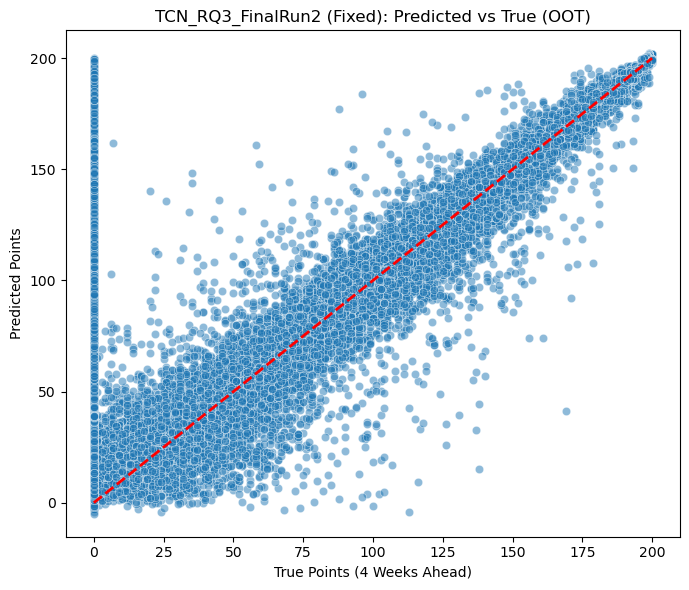

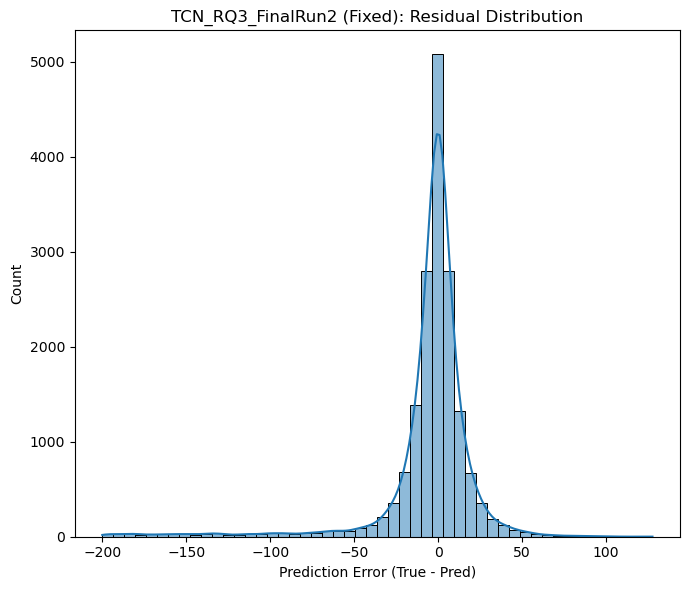

In [14]:
"""
===========================================================
RQ3 – Enhanced TCN Model for 4-Week Prediction (Final Version, Fixed Split)
===========================================================
Author: Taian Peng
Date: 2025-11-01
Fix: Correct time-series OOT split – create sliding windows first, then split by date.
===========================================================
"""

import os, time, joblib, warnings
import numpy as np, pandas as pd, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
from tabulate import tabulate
import matplotlib.pyplot as plt, seaborn as sns

warnings.filterwarnings("ignore")

# ============================================================
# 🔹 Global Settings
# ============================================================
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "TCN_RQ3_FinalRun2"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Using device: {DEVICE}")

# ============================================================
# 🔹 Helper: Sliding Window
# ============================================================
def create_time_windows(df, feature_cols, target_col, seq_len=6, group_col="id"):
    X_list, y_list, d_list = [], [], []
    for _, g in df.groupby(group_col):
        g = g.sort_values("Date")
        Xg, yg, dg = g[feature_cols].to_numpy(), g[target_col].to_numpy(), g["Date"].to_numpy()
        for i in range(len(g) - seq_len + 1):
            X_list.append(Xg[i:i+seq_len])
            y_list.append(yg[i + seq_len - 1])
            d_list.append(dg[i + seq_len - 1])
    if not X_list:
        return np.empty((0, seq_len, len(feature_cols))), np.array([]), np.array([])
    d_arr = np.array(d_list)
    order = np.argsort(d_arr)
    return np.stack(X_list)[order], np.array(y_list)[order], d_arr[order]

# ============================================================
# 🔹 TCN Model Definition
# ============================================================
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=(kernel_size - 1), dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=(kernel_size - 1), dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.norm = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        if out.size(2) != res.size(2):
            min_len = min(out.size(2), res.size(2))
            out, res = out[:, :, :min_len], res[:, :, :min_len]
        out = out + res
        out = out.permute(0, 2, 1)
        out = self.norm(out)
        out = out.permute(0, 2, 1)
        return self.relu(out)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.3, seq_len=6):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            receptive_field = 1 + (kernel_size - 1) * dilation
            if receptive_field > seq_len:
                break
            in_c = num_inputs if i == 0 else num_channels[i - 1]
            out_c = num_channels[i]
            layers.append(TemporalBlock(in_c, out_c, kernel_size, stride=1,
                                        dilation=dilation, dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(layers[-1].conv2.out_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.network(x)
        out = out[:, :, -1]
        return self.fc(out).squeeze(1)

# ============================================================
# 🔹 Training Utility
# ============================================================
def run_training_loop(model, X, y, params, verbose=True):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    n_train = int(len(X_tensor) * 0.9)
    X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
    y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params["batch_size"], shuffle=False)

    model.to(DEVICE)
    criterion = nn.SmoothL1Loss(beta=0.5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["epochs"], eta_min=params["lr"]/50)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_loss, counter = float("inf"), 0
    start = time.time()

    for epoch in range(params["epochs"]):
        model.train(); total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                preds = model(xb)
                loss = criterion(preds, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            total_loss += loss.item()
        scheduler.step()

        model.eval(); val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                val_loss += criterion(preds, yb).item()
        val_loss /= len(val_loader)

        if verbose:
            print(f"Epoch {epoch:03d} | Train={total_loss/len(train_loader):.3f} | Val={val_loss:.3f} | LR={scheduler.get_last_lr()[0]:.2e}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= params["patience"]:
                break

    model.load_state_dict(best_weights)
    print(f"✅ Training done in {time.time()-start:.1f}s | Best Val Loss={best_loss:.3f}")
    return model, best_loss

# ============================================================
# 🔹 Main Execution
# ============================================================
if __name__ == "__main__":
    df = pd.read_csv("Spotify_Model_Ready_Features_RQ3.csv", sep=";", parse_dates=["Date"])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df.sort_values(["id", "Date"], inplace=True)

    FEATURE_COLUMNS = [
        'Danceability','Energy','Loudness_Corrected','Speechiness','Acousticness','Instrumentalness','Valence',
        'Artist_Count','Nationality_Count','Rank','Points (Total)','Rank_last_week','Points_last_week',
        'Rank_change','Points_change','Points_rolling_mean_4w','Rank_rolling_mean_4w','Weeks_on_chart',
        'Artist_Hotness','Degree_Centrality_mean','Degree_Centrality_max','Eigenvector_Centrality_mean',
        'Eigenvector_Centrality_max','Community_Size','Cross_Community_Count','Degree_Disparity','Continent_Diversity'
    ]
    TARGET = "Points_next_4weeks"
    SEQ_LEN = 6

    # ✅ FIXED SPLIT: Create windows first, then split by time
    print("Creating full sliding windows across all data...")
    X_all, y_all, date_all = create_time_windows(df, FEATURE_COLUMNS, TARGET, seq_len=SEQ_LEN)

    split_date = df["Date"].max() - pd.DateOffset(months=3)
    mask_train = date_all < split_date
    mask_oot   = date_all >= split_date

    X_train, y_train = X_all[mask_train], y_all[mask_train]
    X_oot, y_oot, date_oot = X_all[mask_oot], y_all[mask_oot], date_all[mask_oot]
    print(f"✅ Window-based split complete: Train={len(X_train)}, OOT={len(X_oot)}")

    # === Separate Scaling ===
    TEMPORAL = ['Danceability','Energy','Loudness_Corrected','Speechiness','Acousticness','Instrumentalness','Valence',
                'Rank','Points (Total)','Rank_last_week','Points_last_week','Rank_change','Points_change',
                'Points_rolling_mean_4w','Rank_rolling_mean_4w','Weeks_on_chart','Artist_Hotness']
    STATIC = ['Artist_Count','Nationality_Count','Degree_Centrality_mean','Degree_Centrality_max',
              'Eigenvector_Centrality_mean','Eigenvector_Centrality_max','Community_Size',
              'Cross_Community_Count','Degree_Disparity','Continent_Diversity']

    idx_temp = [FEATURE_COLUMNS.index(f) for f in TEMPORAL]
    idx_stat = [FEATURE_COLUMNS.index(f) for f in STATIC]

    sc_t = StandardScaler().fit(X_train[:,:,idx_temp].reshape(-1,len(TEMPORAL)))
    sc_s = StandardScaler().fit(X_train[:,:,idx_stat].reshape(-1,len(STATIC)))

    def scale_mix(X):
        X_scaled = X.copy()
        X_scaled[:,:,idx_temp] = sc_t.transform(X[:,:,idx_temp].reshape(-1,len(TEMPORAL))).reshape(X.shape[0],X.shape[1],len(TEMPORAL))
        X_scaled[:,:,idx_stat] = sc_s.transform(X[:,:,idx_stat].reshape(-1,len(STATIC))).reshape(X.shape[0],X.shape[1],len(STATIC))
        return X_scaled

    X_train_scaled = scale_mix(X_train)
    X_oot_scaled = scale_mix(X_oot)

    # === Train Final Model ===
    final_model = TemporalConvNet(num_inputs=X_train.shape[2],
                                  num_channels=[128, 64, 32],
                                  kernel_size=5, dropout=0.25, seq_len=SEQ_LEN)

    best_params = {"lr": 3e-4, "batch_size": 128, "epochs": 180, "patience": 25}
    print("\n=== Training Final TCN Model on Full Train Data ===")
    final_model, _ = run_training_loop(final_model, X_train_scaled, y_train, best_params, verbose=True)

    torch.save(final_model.state_dict(), os.path.join(OUTPUT_DIR, "model_best.pt"))
    joblib.dump({"temporal_scaler": sc_t, "static_scaler": sc_s}, os.path.join(OUTPUT_DIR, "scaler.pkl"))

    # === 📊 Evaluate on OOT ===
    print("\n=== Evaluating on OOT (Hold-out) Data ===")
    final_model.eval()
    with torch.no_grad():
        preds = final_model(torch.tensor(X_oot_scaled, dtype=torch.float32).to(DEVICE)).cpu().numpy()

    mae = mean_absolute_error(y_oot, preds)
    rmse = np.sqrt(mean_squared_error(y_oot, preds))
    r2 = r2_score(y_oot, preds)
    spearman, _ = spearmanr(y_oot, preds)

    metrics_df = pd.DataFrame({
        "Metric": ["MAE","RMSE","R2","Spearman"],
        "Value": [mae, rmse, r2, spearman]
    })
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics_summary_oot.csv"), sep=";", index=False)

    oot_results = pd.DataFrame({"Date": date_oot, "y_true": y_oot, "y_pred": preds})
    oot_results.to_csv(os.path.join(OUTPUT_DIR, "oot_predictions_and_actuals.csv"), sep=";", index=False)
    print(f"Saved OOT predictions: oot_predictions_and_actuals.csv ({len(oot_results)} rows)")

    print("\n--- OOT Evaluation Summary ---")
    print(tabulate(metrics_df, headers="keys", tablefmt="psql", floatfmt=".4f"))

    # === 📈 Visualization ===
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_oot, y=preds, alpha=0.5)
    plt.plot([y_oot.min(), y_oot.max()], [y_oot.min(), y_oot.max()], 'r--', lw=2)
    plt.xlabel("True Points (4 Weeks Ahead)")
    plt.ylabel("Predicted Points")
    plt.title("TCN_RQ3_FinalRun2 (Fixed): Predicted vs True (OOT)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "pred_vs_true.png"))

    plt.figure(figsize=(7, 6))
    sns.histplot(y_oot - preds, bins=50, kde=True)
    plt.xlabel("Prediction Error (True - Pred)")
    plt.title("TCN_RQ3_FinalRun2 (Fixed): Residual Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "residual_distribution.png"))

    print(f"\n✅ All results and plots saved under: {OUTPUT_DIR}")
